In [1]:
# Setting random seed to obtain reproducible results.
import tensorflow as tf

tf.random.set_seed(42)

import os
import glob
import imageio
import numpy as np
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Initialize global variables.
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 5
NUM_SAMPLES = 32
POS_ENCODE_DIMS = 16
EPOCHS = 50

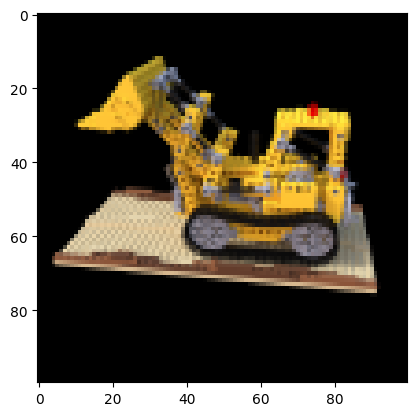

In [2]:
# Download the data if it does not already exist.
file_name = "tiny_nerf_data.npz"
url = "http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz"
if not os.path.exists(file_name):
    data = keras.utils.get_file(fname=file_name, origin=url)

data = np.load(data)
images = data["images"]
im_shape = images.shape
(num_images, H, W, _) = images.shape
(poses, focal) = (data["poses"], data["focal"])

# Plot a random image from the dataset for visualization.
plt.imshow(images[np.random.randint(low=0, high=num_images)])
plt.show()

In [3]:
def encode_position(x):
    """Encodes the position into its corresponding Fourier feature.

    Args:
        x: The input coordinate.

    Returns:
        Fourier features tensors of the position.
    """
    positions = [x]
    for i in range(POS_ENCODE_DIMS):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn(2.0 ** i * x))
    return tf.concat(positions, axis=-1)

In [4]:


def get_rays(height, width, focal, pose):
    """Computes origin point and direction vector of rays.

    Args:
        height: Height of the image.
        width: Width of the image.
        focal: The focal length between the images and the camera.
        pose: The pose matrix of the camera.

    Returns:
        Tuple of origin point and direction vector for rays.
    """
    # Build a meshgrid for the rays.
    i, j = tf.meshgrid(
        tf.range(width, dtype=tf.float32),
        tf.range(height, dtype=tf.float32),
        indexing="xy",
    )

    # Normalize the x axis coordinates.
    transformed_i = (i - width * 0.5) / focal

    # Normalize the y axis coordinates.
    transformed_j = (j - height * 0.5) / focal

    # Create the direction unit vectors.
    directions = tf.stack([transformed_i, -transformed_j, -tf.ones_like(i)], axis=-1)

    # Get the camera matrix.
    camera_matrix = pose[:3, :3]
    height_width_focal = pose[:3, -1]

    # Get origins and directions for the rays.
    transformed_dirs = directions[..., None, :]
    camera_dirs = transformed_dirs * camera_matrix
    ray_directions = tf.reduce_sum(camera_dirs, axis=-1)
    ray_origins = tf.broadcast_to(height_width_focal, tf.shape(ray_directions))

    # Return the origins and directions.
    return (ray_origins, ray_directions)

In [5]:
def render_flat_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
    """Renders the rays and flattens it.

    Args:
        ray_origins: The origin points for rays.
        ray_directions: The direction unit vectors for the rays.
        near: The near bound of the volumetric scene.
        far: The far bound of the volumetric scene.
        num_samples: Number of sample points in a ray.
        rand: Choice for randomising the sampling strategy.

    Returns:
       Tuple of flattened rays and sample points on each rays.
    """
    # Compute 3D query points.
    # Equation: r(t) = o+td -> Building the "t" here.
    t_vals = tf.linspace(near, far, num_samples)
    if rand:
        # Inject uniform noise into sample space to make the sampling
        # continuous.
        shape = list(ray_origins.shape[:-1]) + [num_samples]
        noise = tf.random.uniform(shape=shape) * (far - near) / num_samples
        t_vals = t_vals + noise

    # Equation: r(t) = o + td -> Building the "r" here.
    rays = ray_origins[..., None, :] + (
        ray_directions[..., None, :] * t_vals[..., None]
    )
    rays_flat = tf.reshape(rays, [-1, 3])
    rays_flat = encode_position(rays_flat)
    return (rays_flat, t_vals)

In [6]:
def map_fn(pose):
    """Maps individual pose to flattened rays and sample points.

    Args:
        pose: The pose matrix of the camera.

    Returns:
        Tuple of flattened rays and sample points corresponding to the
        camera pose.
    """
    (ray_origins, ray_directions) = get_rays(height=H, width=W, focal=focal, pose=pose)
    (rays_flat, t_vals) = render_flat_rays(
        ray_origins=ray_origins,
        ray_directions=ray_directions,
        near=2.0,
        far=6.0,
        num_samples=NUM_SAMPLES,
        rand=True,
    )
    return (rays_flat, t_vals)


# Create the training split.
split_index = int(num_images * 0.8)

# Split the images into training and validation.
train_images = images[:split_index]
val_images = images[split_index:]

# Split the poses into training and validation.
train_poses = poses[:split_index]
val_poses = poses[split_index:]

# Make the training pipeline.
train_img_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses)
train_ray_ds = train_pose_ds.map(map_fn, num_parallel_calls=AUTO)
training_ds = tf.data.Dataset.zip((train_img_ds, train_ray_ds))
train_ds = (
    training_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# Make the validation pipeline.
val_img_ds = tf.data.Dataset.from_tensor_slices(val_images)
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses)
val_ray_ds = val_pose_ds.map(map_fn, num_parallel_calls=AUTO)
validation_ds = tf.data.Dataset.zip((val_img_ds, val_ray_ds))
val_ds = (
    validation_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

In [7]:
def get_nerf_model(num_layers, num_pos):
    """Generates the NeRF neural network.

    Args:
        num_layers: The number of MLP layers.
        num_pos: The number of dimensions of positional encoding.

    Returns:
        The [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) model.
    """
    inputs = keras.Input(shape=(num_pos, 2 * 3 * POS_ENCODE_DIMS + 3))
    x = inputs
    for i in range(num_layers):
        x = layers.Dense(units=64, activation="relu")(x)
        if i % 4 == 0 and i > 0:
            # Inject residual connection.
            x = layers.concatenate([x, inputs], axis=-1)
    outputs = layers.Dense(units=4)(x)
    return keras.Model(inputs=inputs, outputs=outputs)


def render_rgb_depth(model, rays_flat, t_vals, rand=True, train=True):
    """Generates the RGB image and depth map from model prediction.

    Args:
        model: The MLP model that is trained to predict the rgb and
            volume density of the volumetric scene.
        rays_flat: The flattened rays that serve as the input to
            the NeRF model.
        t_vals: The sample points for the rays.
        rand: Choice to randomise the sampling strategy.
        train: Whether the model is in the training or testing phase.

    Returns:
        Tuple of rgb image and depth map.
    """
    # Get the predictions from the nerf model and reshape it.
    if train:
        predictions = model(rays_flat)
    else:
        predictions = model.predict(rays_flat)
    predictions = tf.reshape(predictions, shape=(BATCH_SIZE, H, W, NUM_SAMPLES, 4))

    # Slice the predictions into rgb and sigma.
    rgb = tf.sigmoid(predictions[..., :-1])
    sigma_a = tf.nn.relu(predictions[..., -1])

    # Get the distance of adjacent intervals.
    delta = t_vals[..., 1:] - t_vals[..., :-1]
    # delta shape = (num_samples)
    if rand:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, H, W, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta)
    else:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta[:, None, None, :])

    # Get transmittance.
    exp_term = 1.0 - alpha
    epsilon = 1e-10
    transmittance = tf.math.cumprod(exp_term + epsilon, axis=-1, exclusive=True)
    weights = alpha * transmittance
    rgb = tf.reduce_sum(weights[..., None] * rgb, axis=-2)

    if rand:
        depth_map = tf.reduce_sum(weights * t_vals, axis=-1)
    else:
        depth_map = tf.reduce_sum(weights * t_vals[:, None, None], axis=-1)
    return (rgb, depth_map)

Training

Epoch 1/50
1/1 [==============================] - 4s 4s/step- loss: 0.0870 - psnr: 11.00


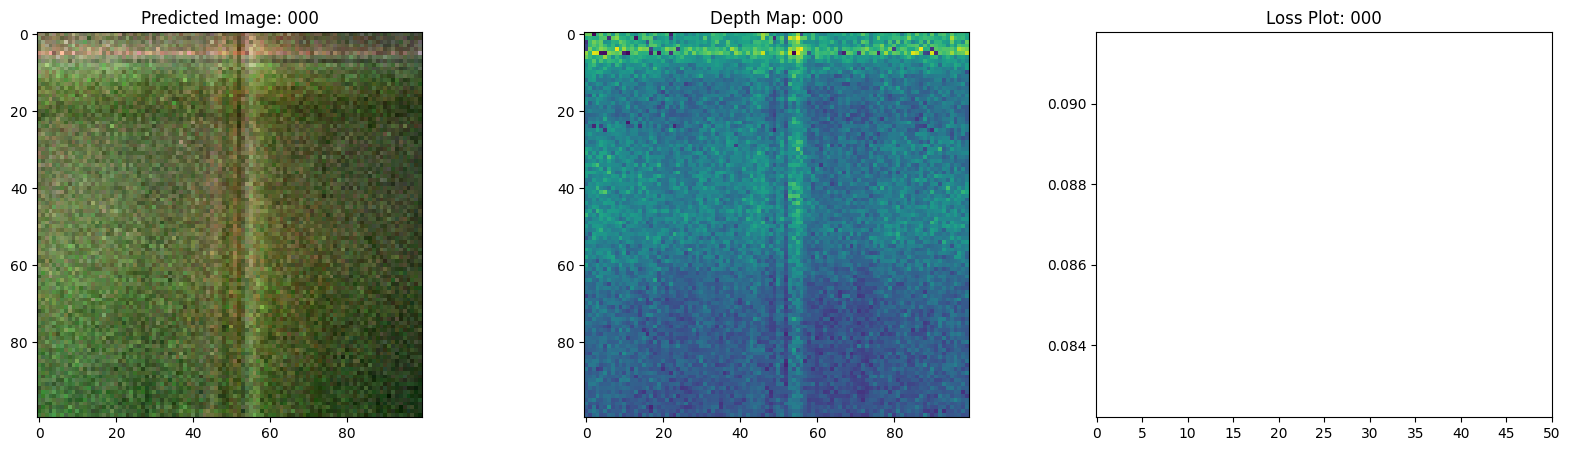

16/16 [==============================] - 154s 6s/step - loss: 0.0870 - psnr: 11.0070 - val_loss: 0.0749 - val_psnr: 11.7731
Epoch 2/50
1/1 [==============================] - 3s 3s/step- loss: 0.0623 - psnr: 12.45


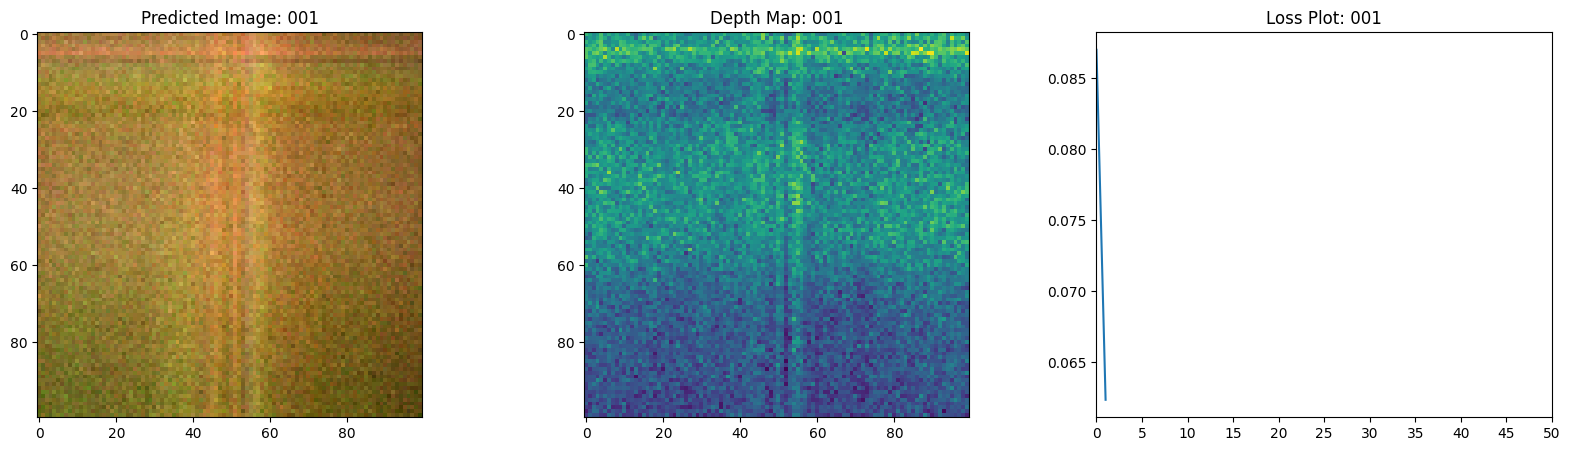

16/16 [==============================] - 111s 6s/step - loss: 0.0623 - psnr: 12.4559 - val_loss: 0.0653 - val_psnr: 12.2008
Epoch 3/50
1/1 [==============================] - 3s 3s/step- loss: 0.0590 - psnr: 12.72


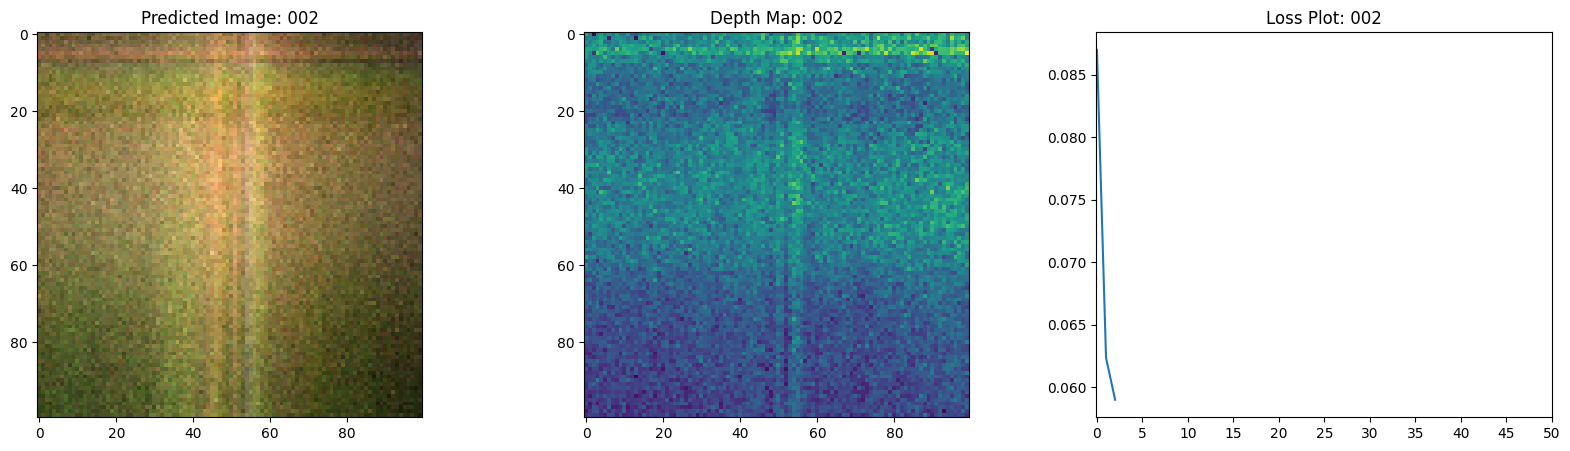

16/16 [==============================] - 107s 6s/step - loss: 0.0590 - psnr: 12.7268 - val_loss: 0.0652 - val_psnr: 12.1496
Epoch 4/50
1/1 [==============================] - 3s 3s/step- loss: 0.0568 - psnr: 12.88


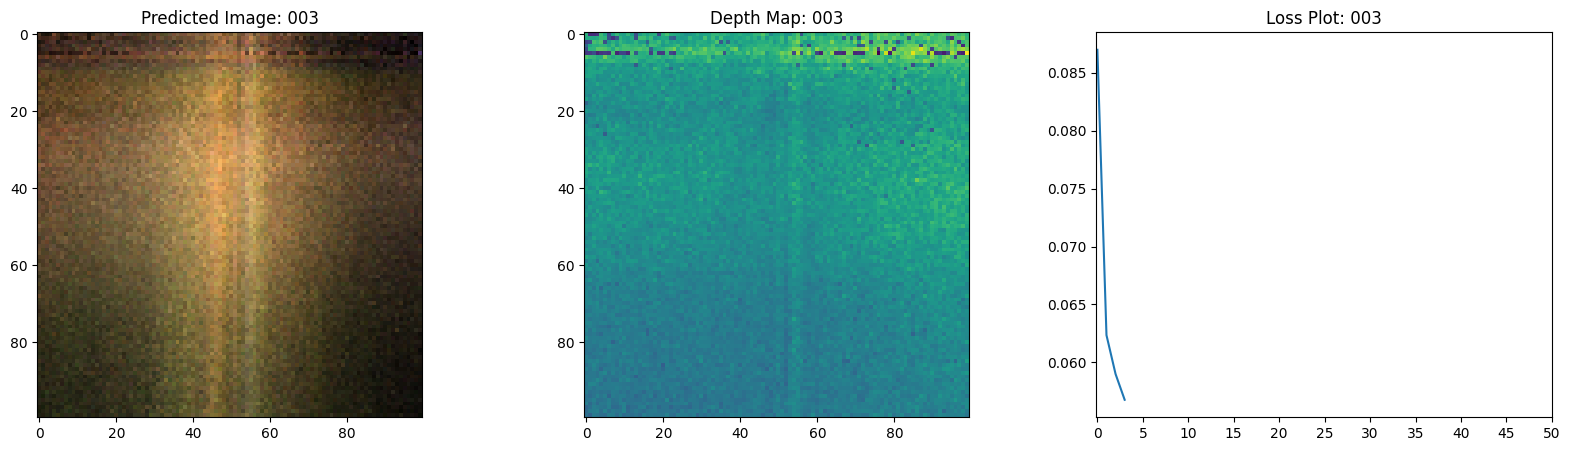

16/16 [==============================] - 112s 6s/step - loss: 0.0568 - psnr: 12.8844 - val_loss: 0.0598 - val_psnr: 12.6132
Epoch 5/50
1/1 [==============================] - 3s 3s/step- loss: 0.0512 - psnr: 13.29


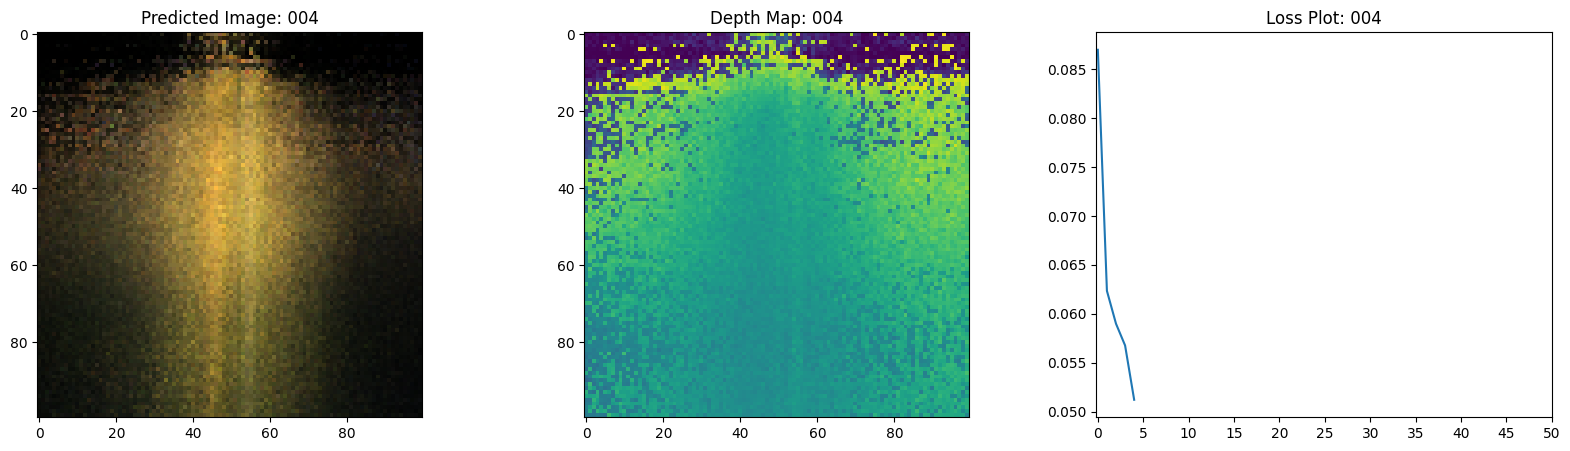

16/16 [==============================] - 109s 6s/step - loss: 0.0512 - psnr: 13.2989 - val_loss: 0.0462 - val_psnr: 13.6919
Epoch 6/50
1/1 [==============================] - 3s 3s/step- loss: 0.0372 - psnr: 14.64


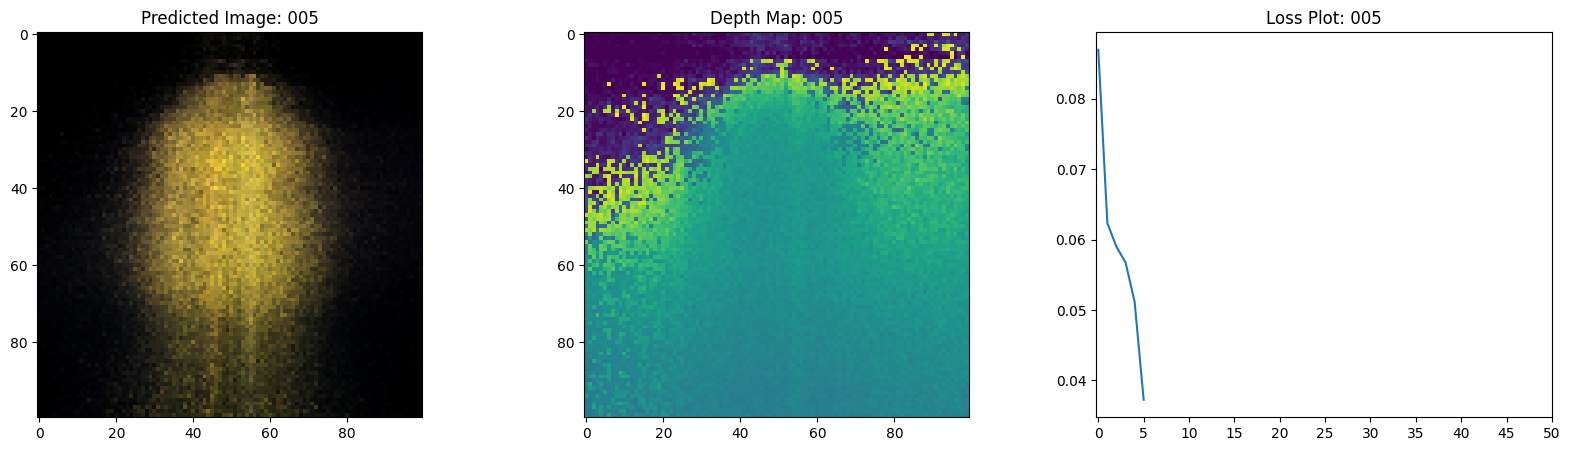

16/16 [==============================] - 110s 7s/step - loss: 0.0372 - psnr: 14.6462 - val_loss: 0.0329 - val_psnr: 15.0444
Epoch 7/50
1/1 [==============================] - 3s 3s/step- loss: 0.0297 - psnr: 15.52


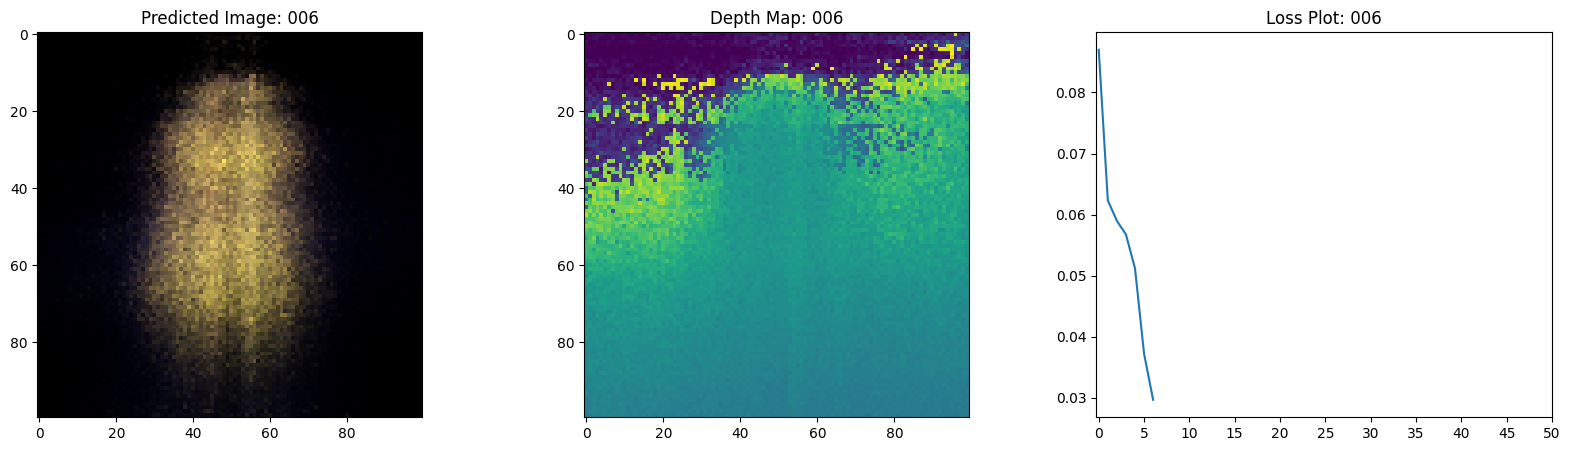

16/16 [==============================] - 106s 6s/step - loss: 0.0297 - psnr: 15.5287 - val_loss: 0.0280 - val_psnr: 15.6217
Epoch 8/50
1/1 [==============================] - 3s 3s/step- loss: 0.0262 - psnr: 16.04


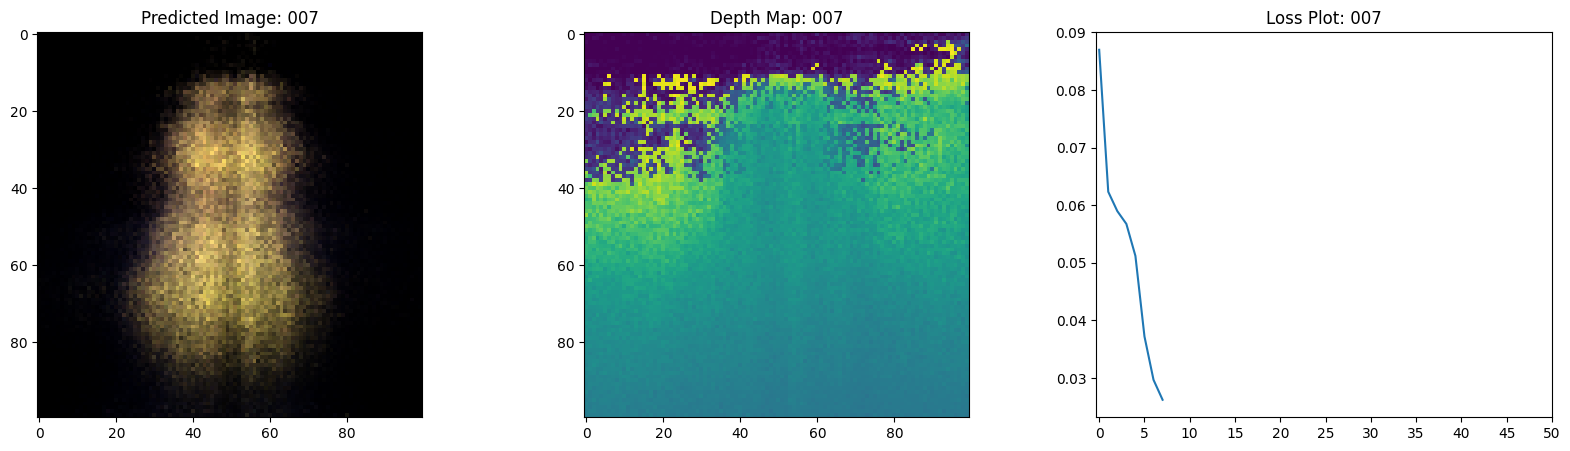

16/16 [==============================] - 109s 6s/step - loss: 0.0262 - psnr: 16.0430 - val_loss: 0.0253 - val_psnr: 16.1534
Epoch 9/50
1/1 [==============================] - 3s 3s/step- loss: 0.0240 - psnr: 16.42


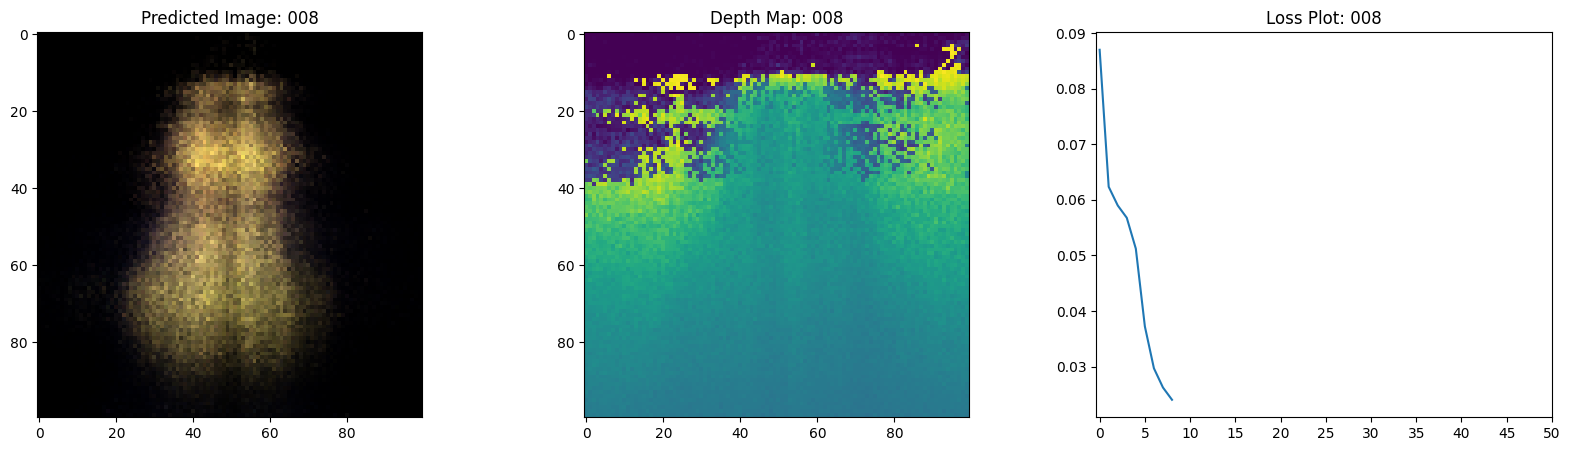

16/16 [==============================] - 105s 6s/step - loss: 0.0240 - psnr: 16.4205 - val_loss: 0.0224 - val_psnr: 16.6567
Epoch 10/50
1/1 [==============================] - 3s 3s/step- loss: 0.0227 - psnr: 16.66


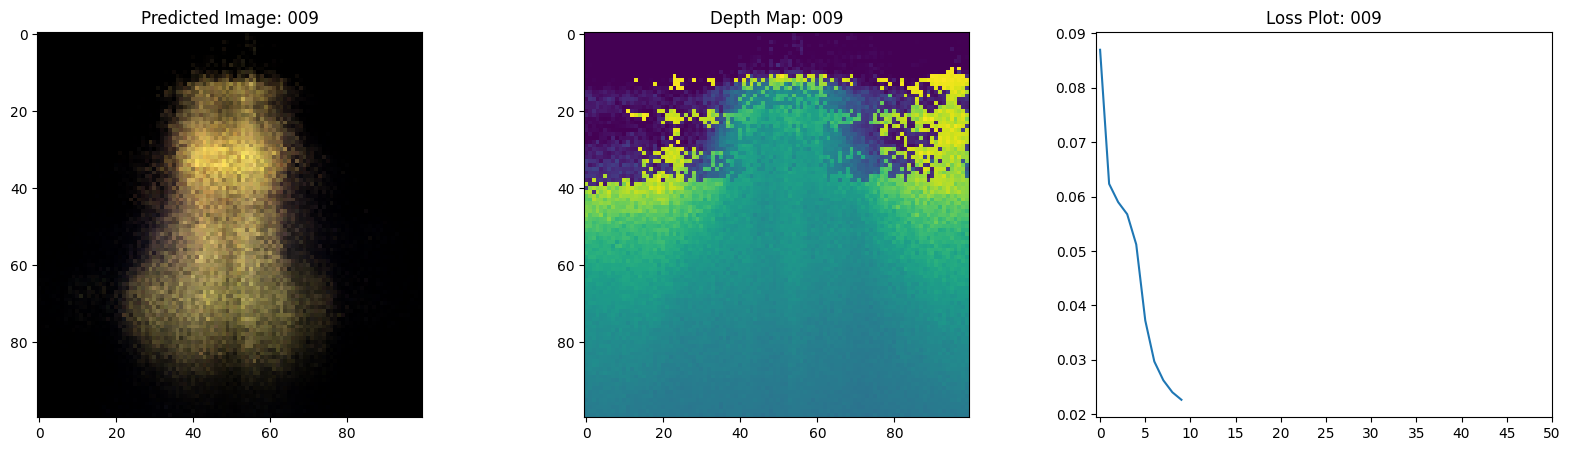

16/16 [==============================] - 111s 6s/step - loss: 0.0227 - psnr: 16.6637 - val_loss: 0.0209 - val_psnr: 16.9303
Epoch 11/50
1/1 [==============================] - 3s 3s/step- loss: 0.0206 - psnr: 17.03


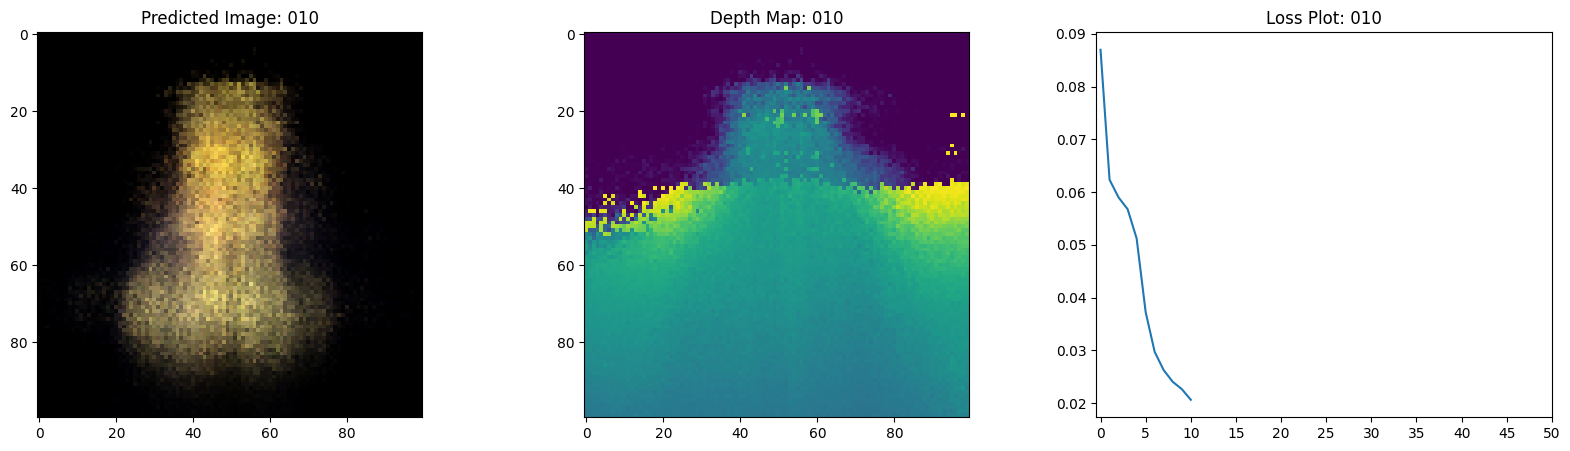

16/16 [==============================] - 102s 6s/step - loss: 0.0206 - psnr: 17.0389 - val_loss: 0.0198 - val_psnr: 17.1912
Epoch 12/50
1/1 [==============================] - 3s 3s/step- loss: 0.0182 - psnr: 17.55


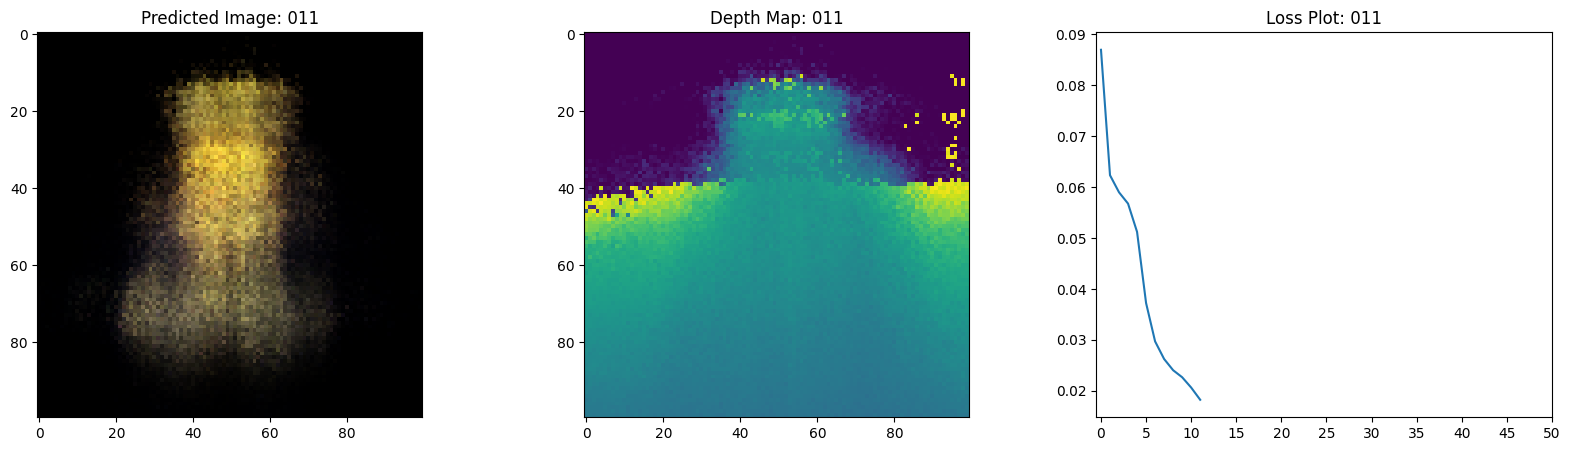

16/16 [==============================] - 104s 6s/step - loss: 0.0182 - psnr: 17.5566 - val_loss: 0.0172 - val_psnr: 17.7367
Epoch 13/50
1/1 [==============================] - 3s 3s/step- loss: 0.0169 - psnr: 17.88


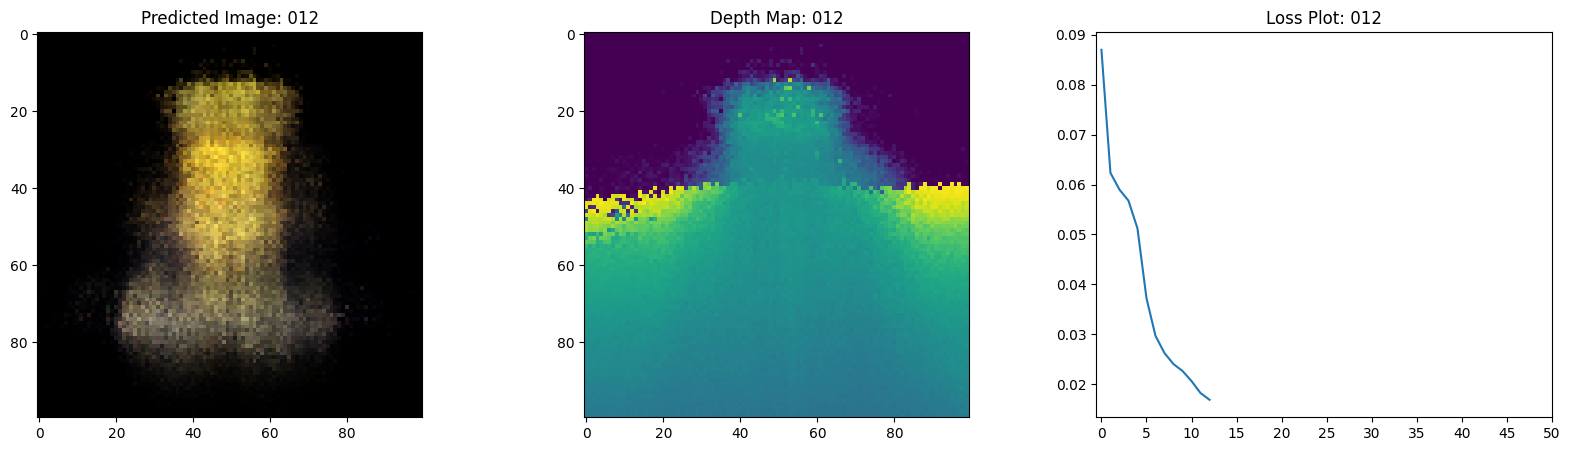

16/16 [==============================] - 109s 6s/step - loss: 0.0169 - psnr: 17.8806 - val_loss: 0.0165 - val_psnr: 17.9191
Epoch 14/50
1/1 [==============================] - 3s 3s/step- loss: 0.0162 - psnr: 18.05


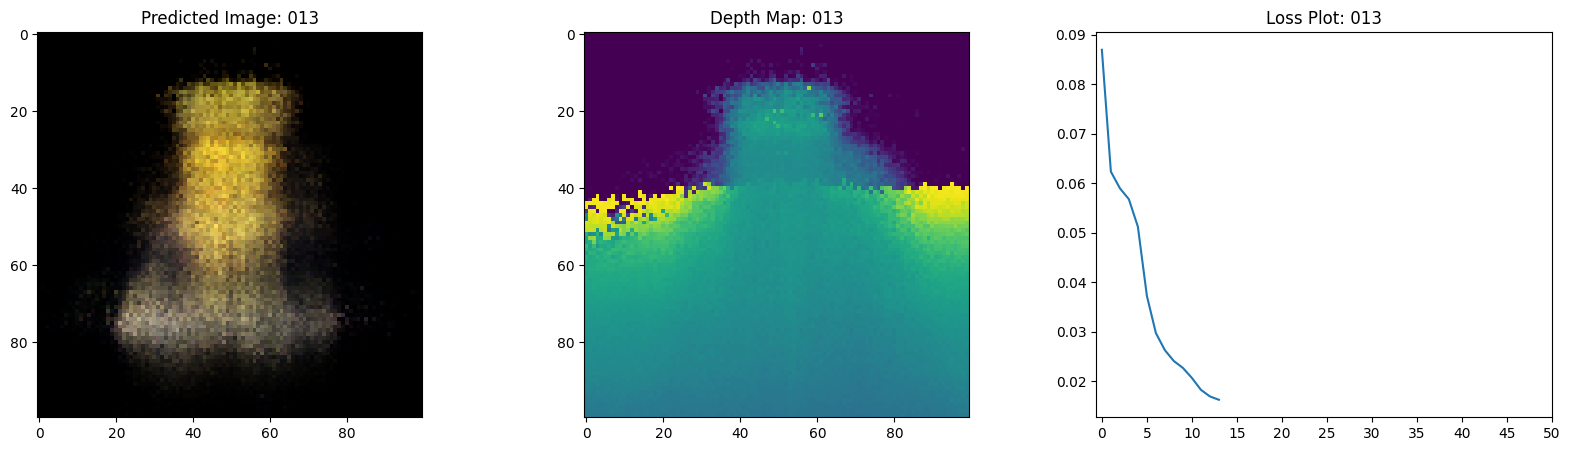

16/16 [==============================] - 106s 6s/step - loss: 0.0162 - psnr: 18.0566 - val_loss: 0.0154 - val_psnr: 18.2095
Epoch 15/50
1/1 [==============================] - 3s 3s/step- loss: 0.0153 - psnr: 18.34


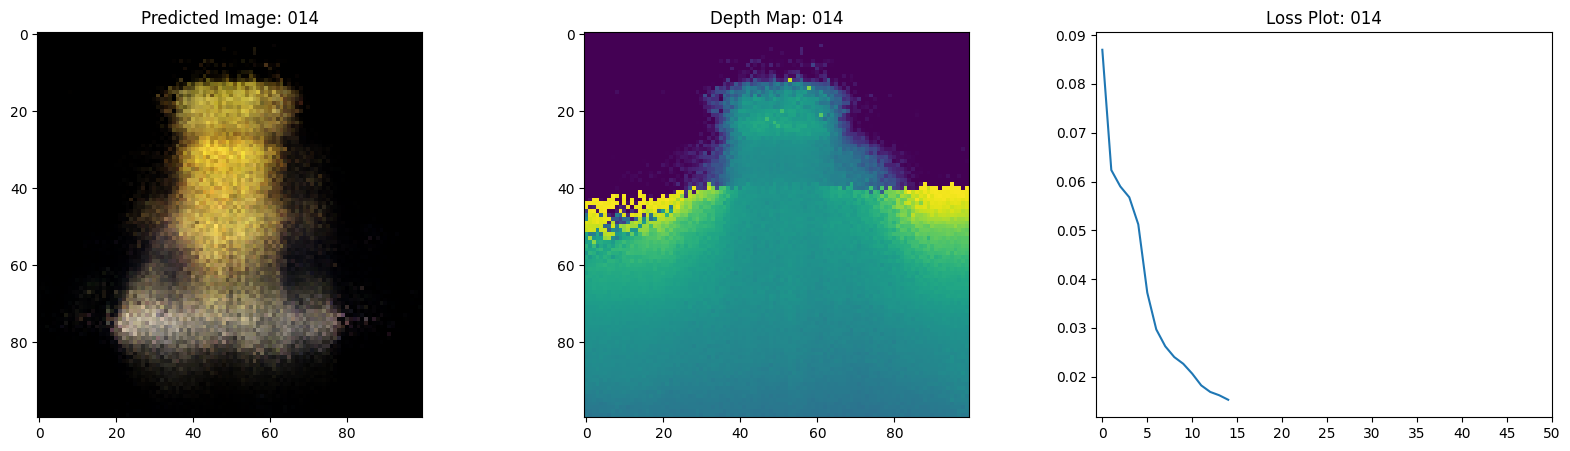

16/16 [==============================] - 105s 6s/step - loss: 0.0153 - psnr: 18.3472 - val_loss: 0.0154 - val_psnr: 18.1975
Epoch 16/50
1/1 [==============================] - 3s 3s/step- loss: 0.0151 - psnr: 18.34


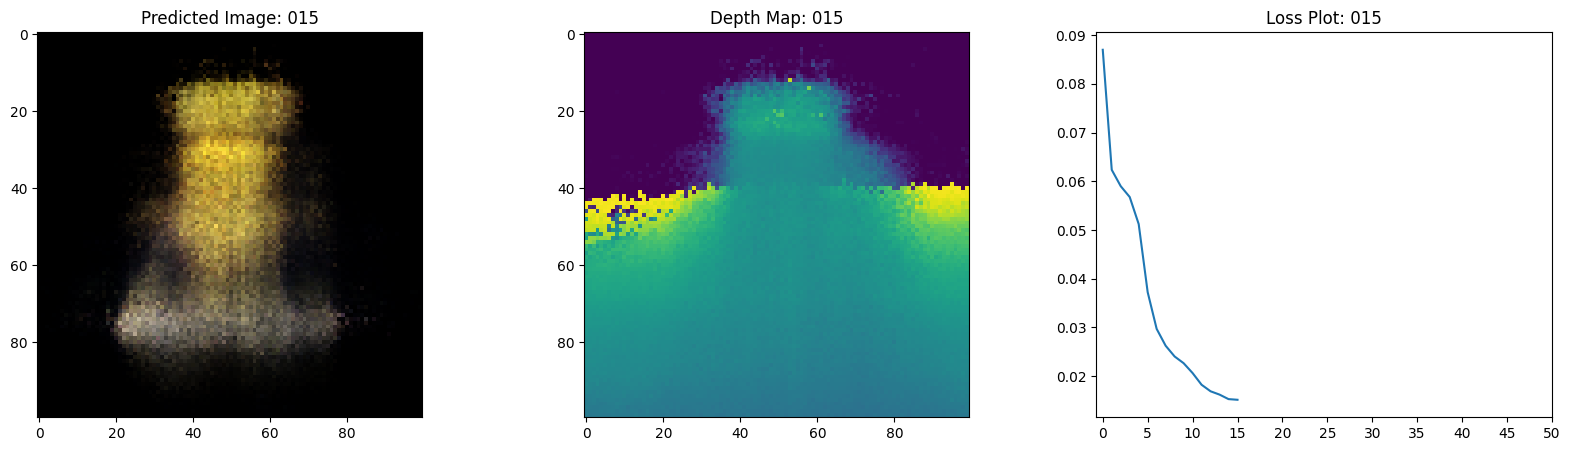

16/16 [==============================] - 104s 6s/step - loss: 0.0151 - psnr: 18.3425 - val_loss: 0.0146 - val_psnr: 18.4499
Epoch 17/50
1/1 [==============================] - 3s 3s/step- loss: 0.0142 - psnr: 18.66


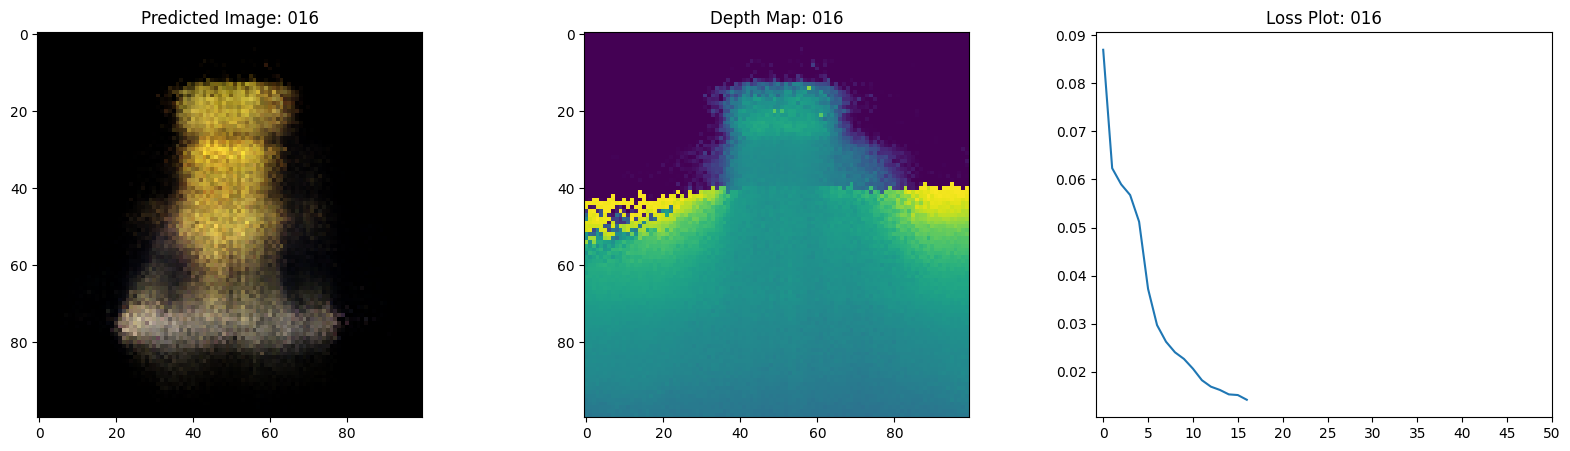

16/16 [==============================] - 109s 6s/step - loss: 0.0142 - psnr: 18.6683 - val_loss: 0.0139 - val_psnr: 18.6856
Epoch 18/50
1/1 [==============================] - 3s 3s/step- loss: 0.0132 - psnr: 18.93


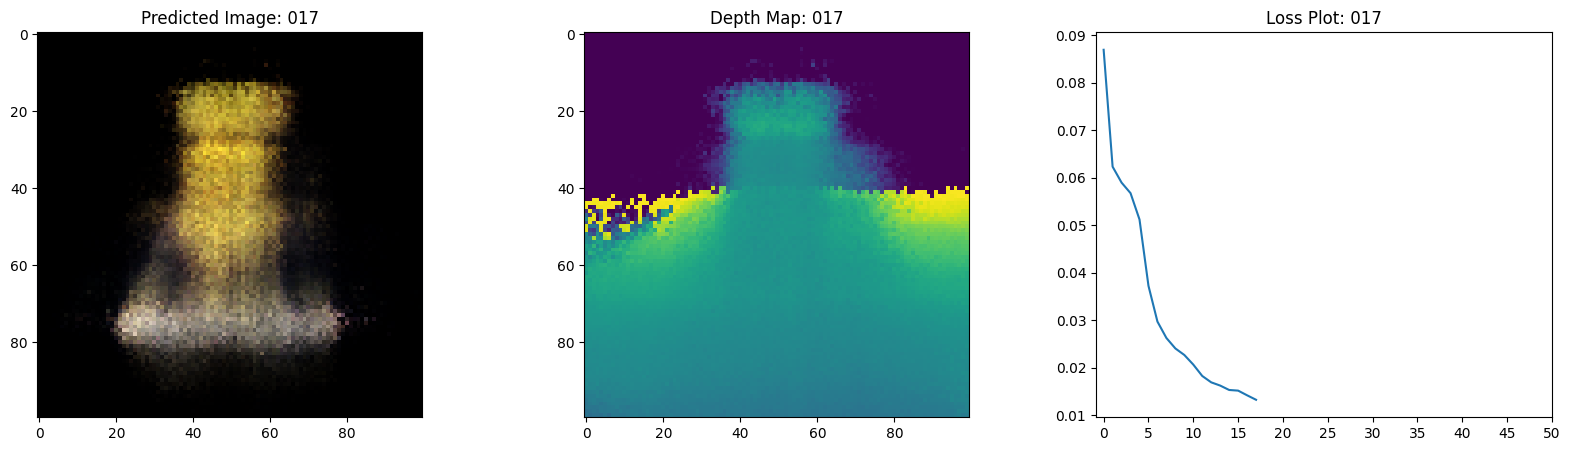

16/16 [==============================] - 102s 6s/step - loss: 0.0132 - psnr: 18.9366 - val_loss: 0.0141 - val_psnr: 18.5880
Epoch 19/50
1/1 [==============================] - 3s 3s/step- loss: 0.0130 - psnr: 19.02


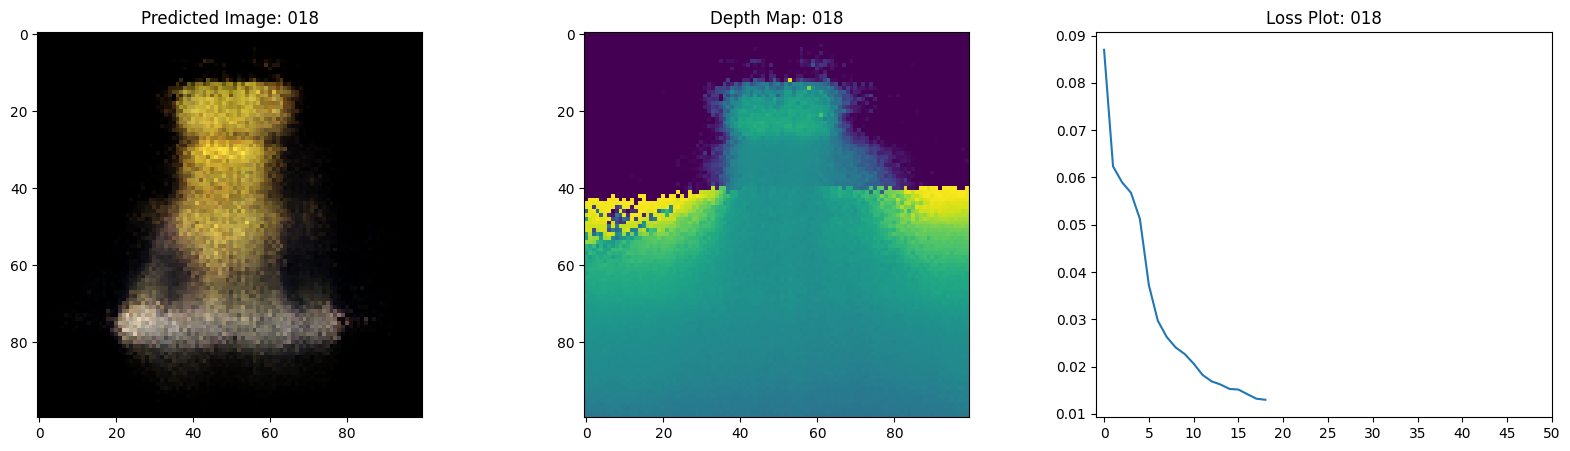

16/16 [==============================] - 108s 6s/step - loss: 0.0130 - psnr: 19.0238 - val_loss: 0.0129 - val_psnr: 18.9844
Epoch 20/50
1/1 [==============================] - 4s 4s/step- loss: 0.0129 - psnr: 19.03


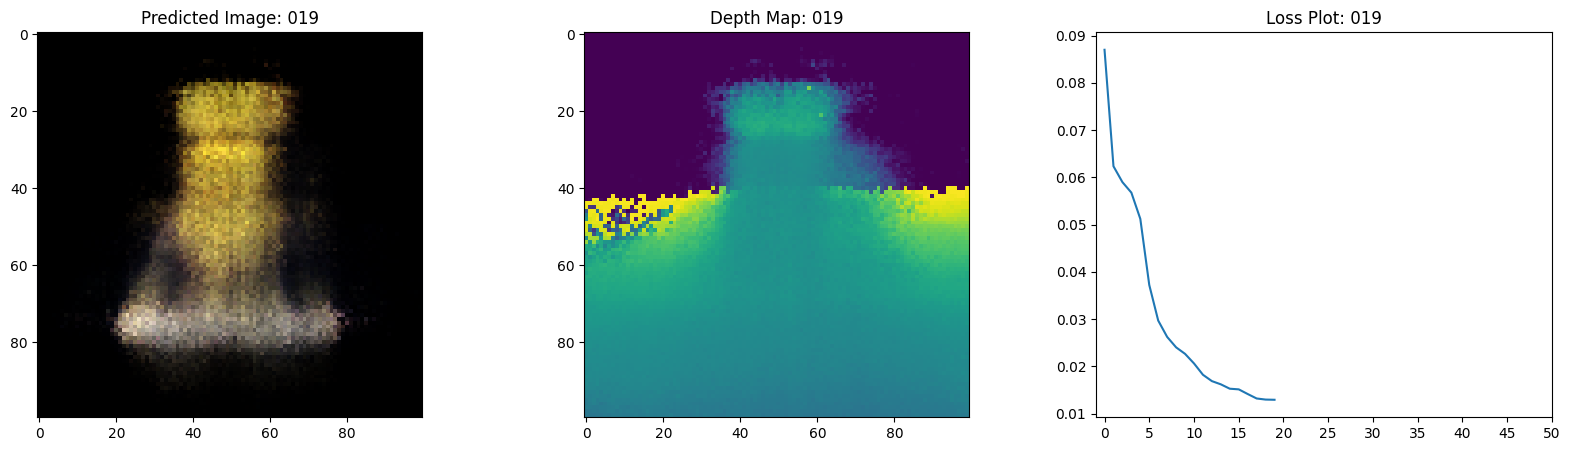

16/16 [==============================] - 106s 6s/step - loss: 0.0129 - psnr: 19.0361 - val_loss: 0.0127 - val_psnr: 19.0865
Epoch 21/50
1/1 [==============================] - 3s 3s/step- loss: 0.0123 - psnr: 19.25


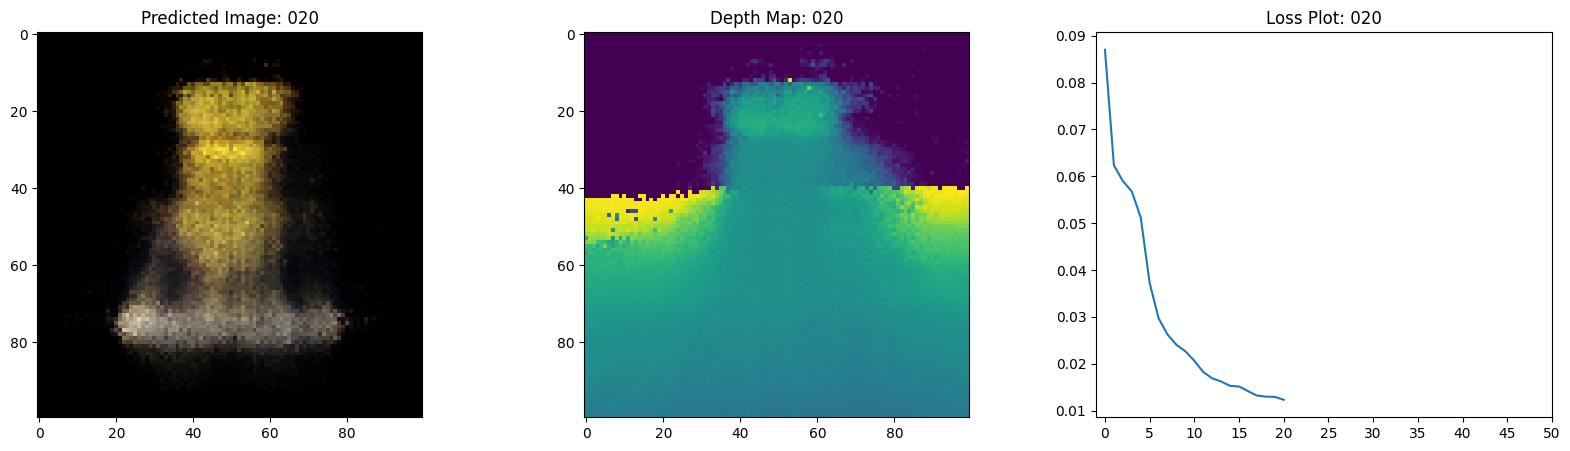

16/16 [==============================] - 103s 6s/step - loss: 0.0123 - psnr: 19.2529 - val_loss: 0.0123 - val_psnr: 19.2066
Epoch 22/50
1/1 [==============================] - 3s 3s/step- loss: 0.0121 - psnr: 19.33


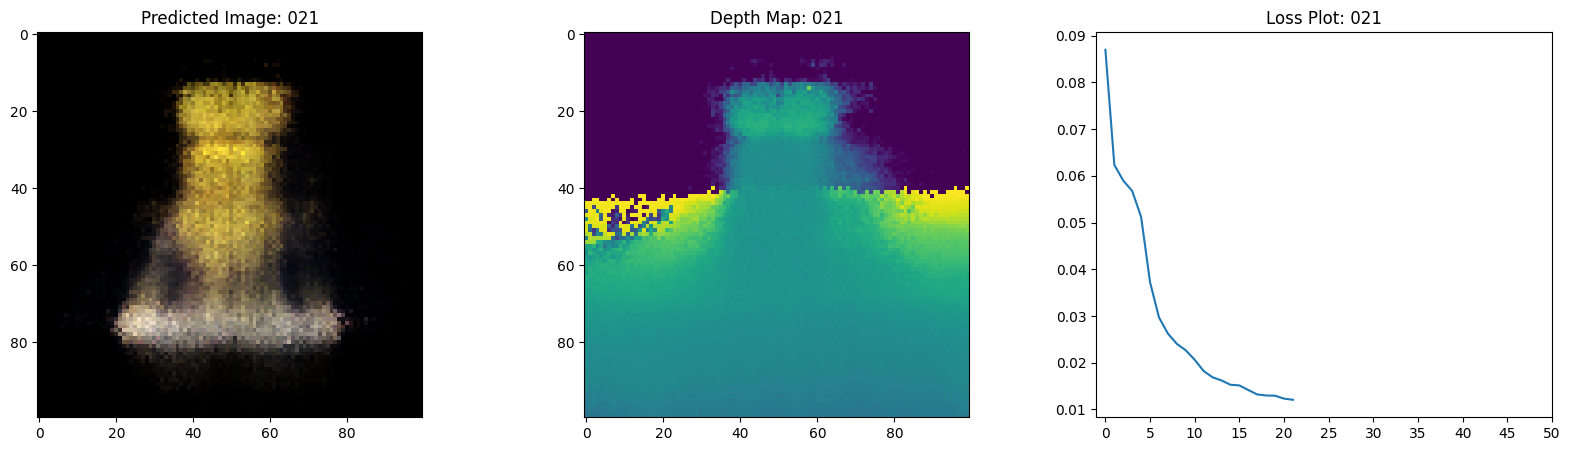

16/16 [==============================] - 109s 6s/step - loss: 0.0121 - psnr: 19.3305 - val_loss: 0.0125 - val_psnr: 19.0776
Epoch 23/50
1/1 [==============================] - 3s 3s/step- loss: 0.0118 - psnr: 19.43


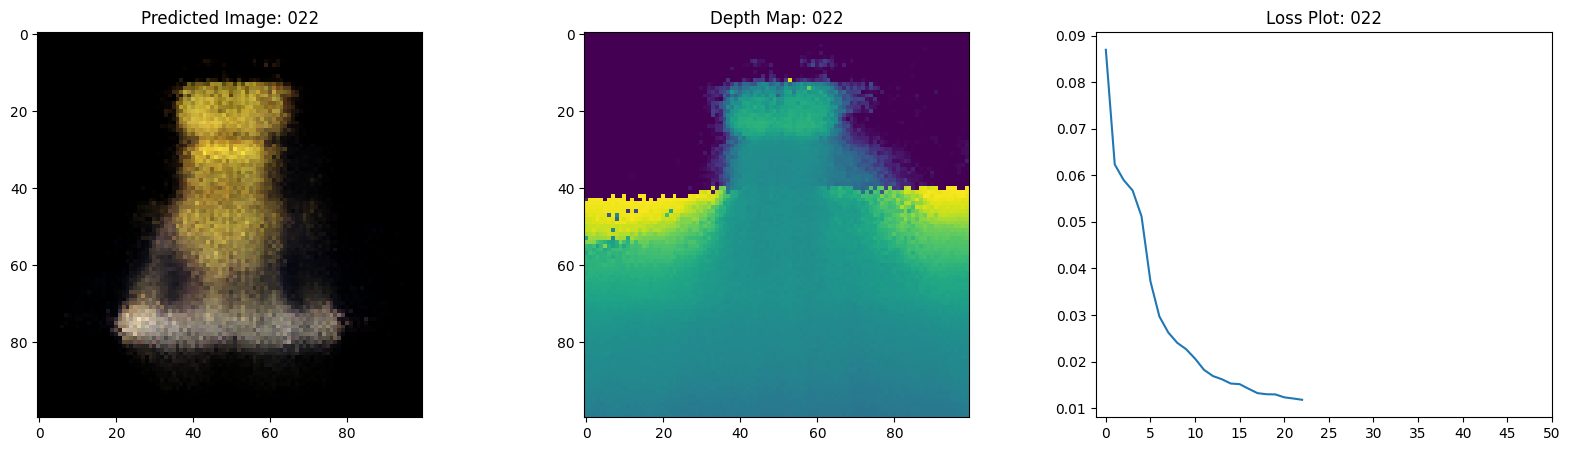

16/16 [==============================] - 105s 6s/step - loss: 0.0118 - psnr: 19.4305 - val_loss: 0.0117 - val_psnr: 19.3677
Epoch 24/50
1/1 [==============================] - 3s 3s/step- loss: 0.0115 - psnr: 19.56


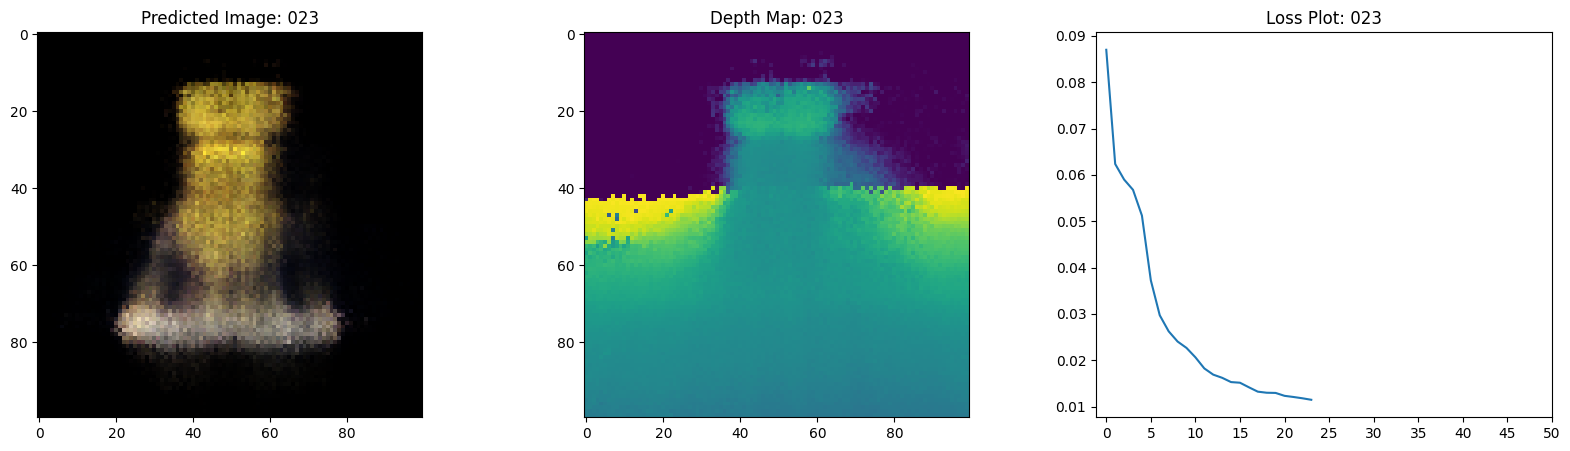

16/16 [==============================] - 102s 6s/step - loss: 0.0115 - psnr: 19.5649 - val_loss: 0.0114 - val_psnr: 19.5568
Epoch 25/50
1/1 [==============================] - 3s 3s/step- loss: 0.0112 - psnr: 19.64


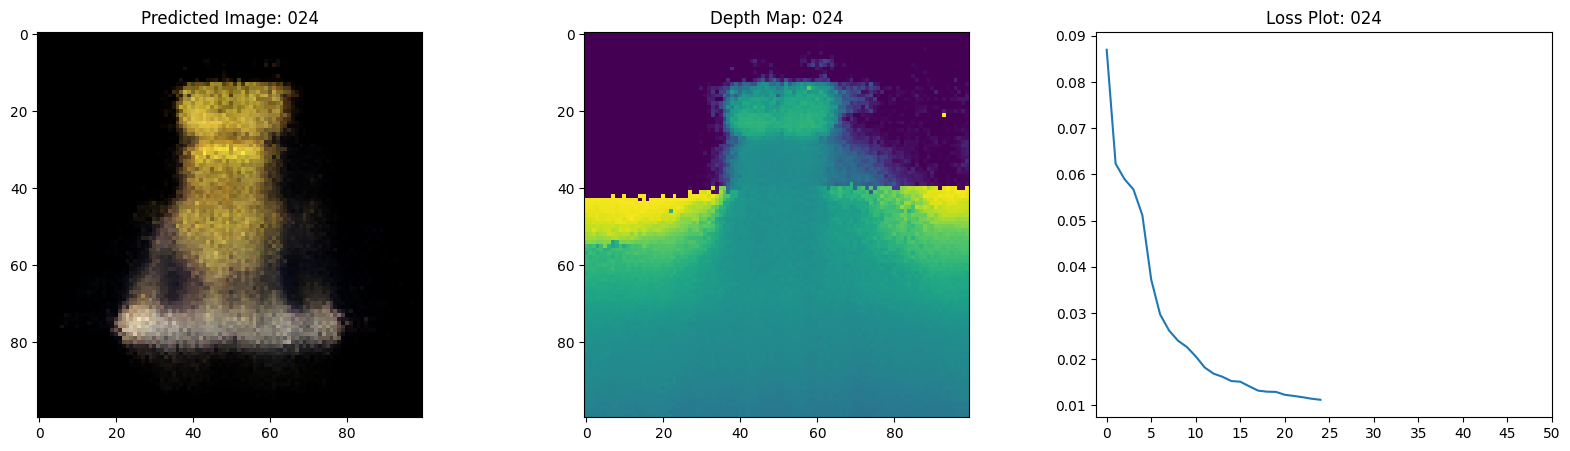

16/16 [==============================] - 109s 6s/step - loss: 0.0112 - psnr: 19.6420 - val_loss: 0.0112 - val_psnr: 19.6338
Epoch 26/50
1/1 [==============================] - 3s 3s/step- loss: 0.0112 - psnr: 19.67


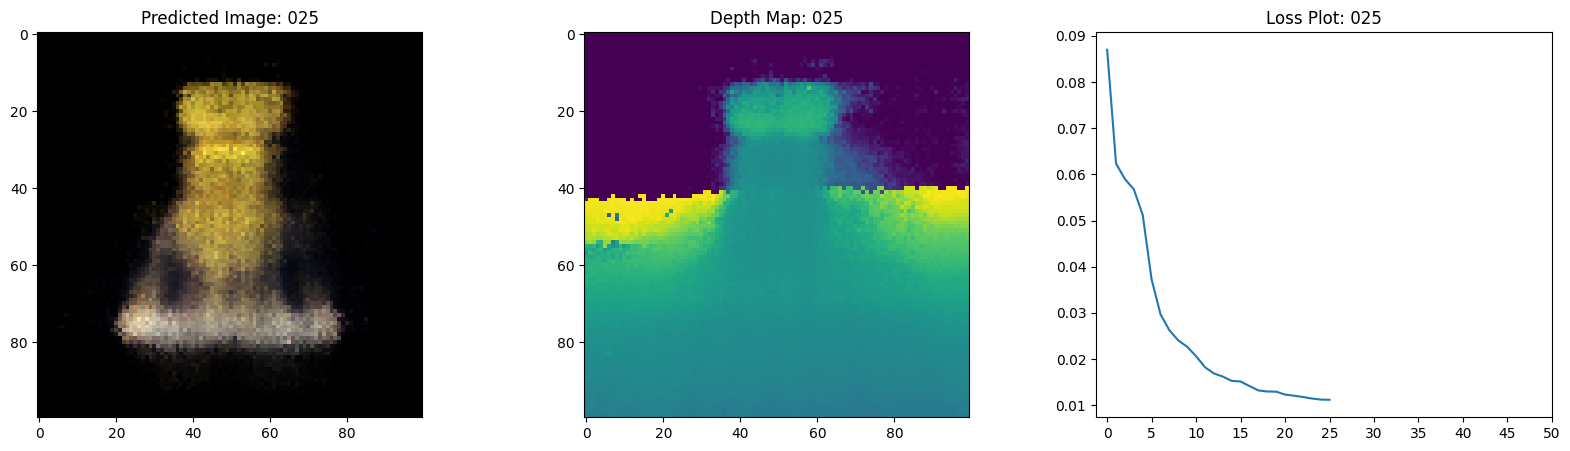

16/16 [==============================] - 103s 6s/step - loss: 0.0112 - psnr: 19.6797 - val_loss: 0.0113 - val_psnr: 19.5392
Epoch 27/50
1/1 [==============================] - 3s 3s/step- loss: 0.0109 - psnr: 19.78


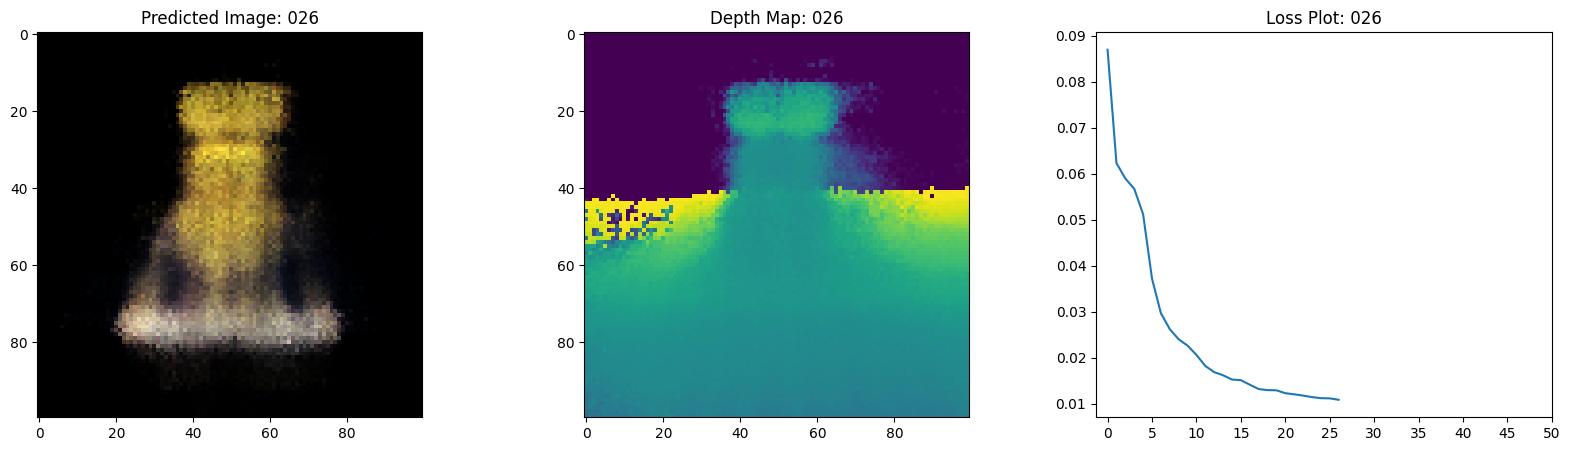

16/16 [==============================] - 101s 6s/step - loss: 0.0109 - psnr: 19.7855 - val_loss: 0.0111 - val_psnr: 19.6205
Epoch 28/50
1/1 [==============================] - 3s 3s/step- loss: 0.0105 - psnr: 19.94


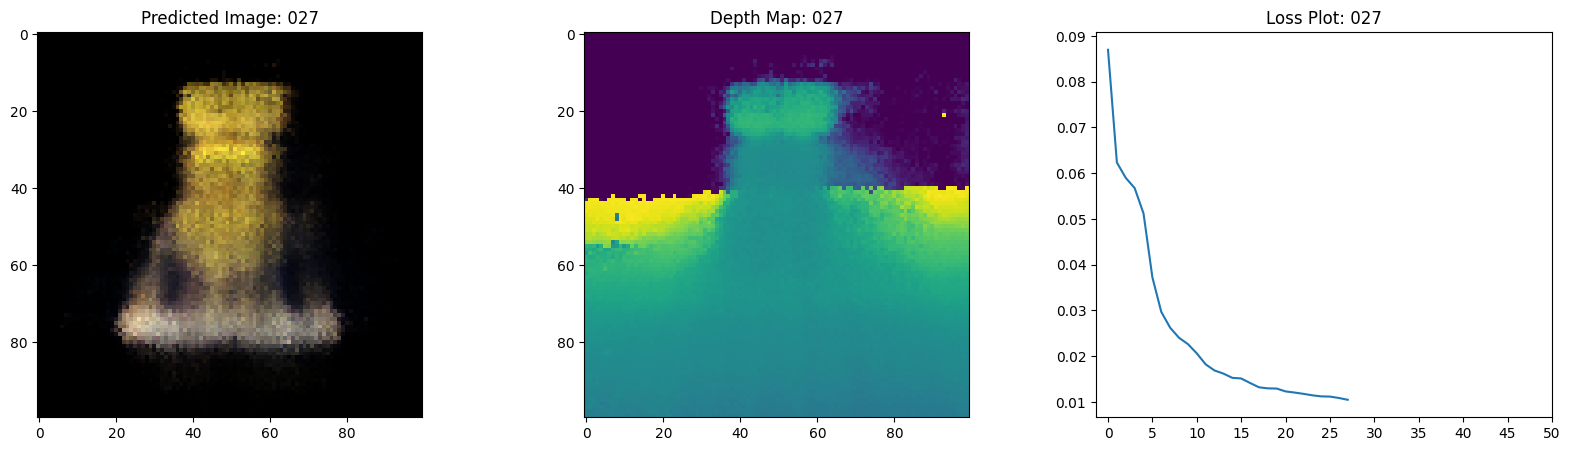

16/16 [==============================] - 103s 6s/step - loss: 0.0105 - psnr: 19.9459 - val_loss: 0.0108 - val_psnr: 19.7442
Epoch 29/50
1/1 [==============================] - 3s 3s/step- loss: 0.0104 - psnr: 19.97


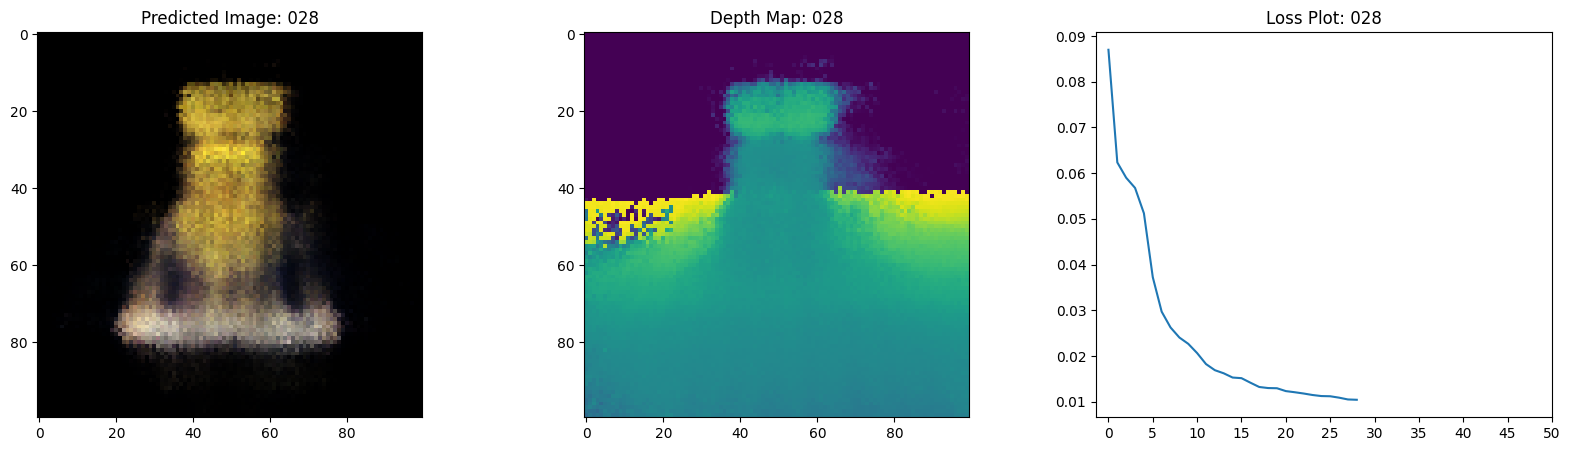

16/16 [==============================] - 109s 6s/step - loss: 0.0104 - psnr: 19.9720 - val_loss: 0.0108 - val_psnr: 19.7327
Epoch 30/50
1/1 [==============================] - 3s 3s/step- loss: 0.0103 - psnr: 20.03


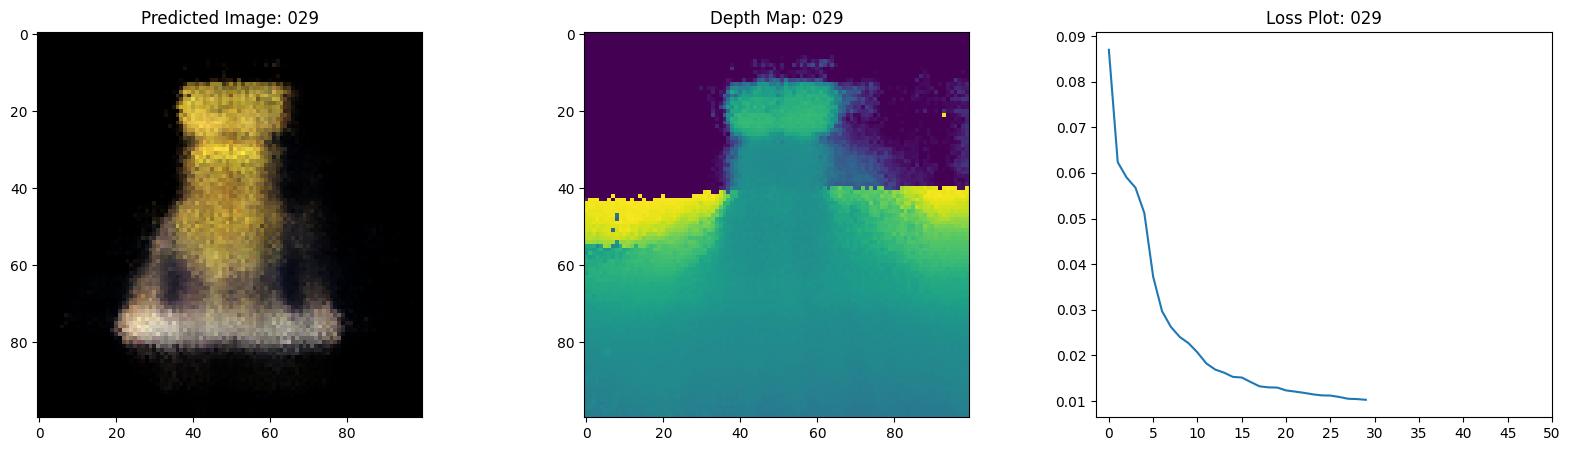

16/16 [==============================] - 107s 6s/step - loss: 0.0103 - psnr: 20.0337 - val_loss: 0.0102 - val_psnr: 20.0433
Epoch 31/50
1/1 [==============================] - 4s 4s/step- loss: 0.0100 - psnr: 20.13


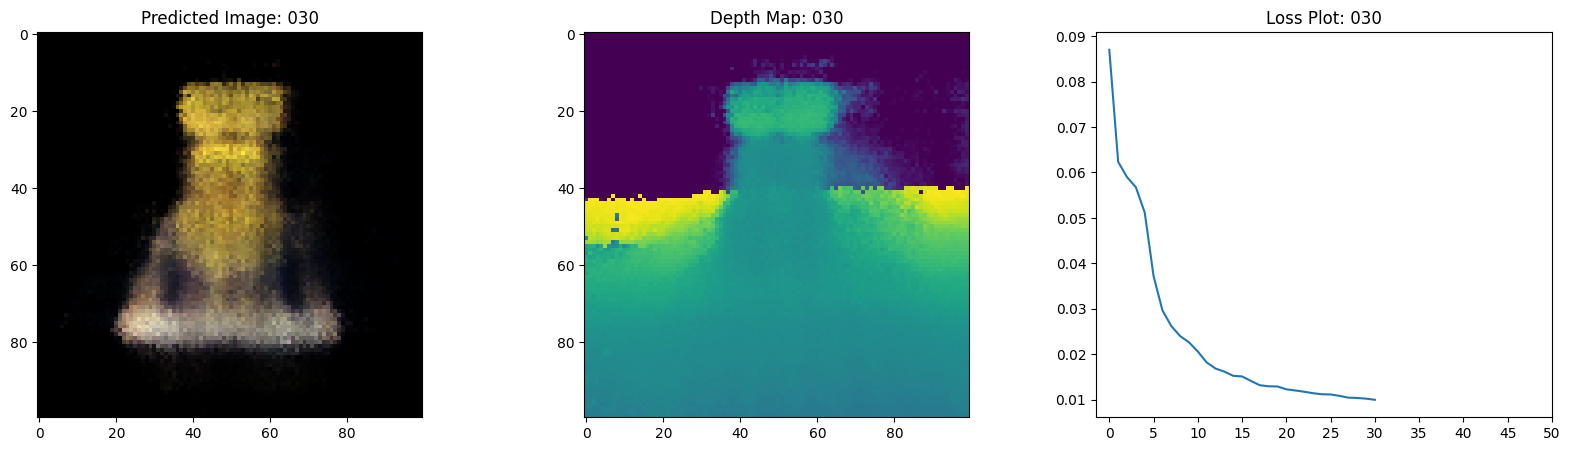

16/16 [==============================] - 106s 6s/step - loss: 0.0100 - psnr: 20.1345 - val_loss: 0.0101 - val_psnr: 20.1022
Epoch 32/50
1/1 [==============================] - 4s 4s/step- loss: 0.0096 - psnr: 20.34


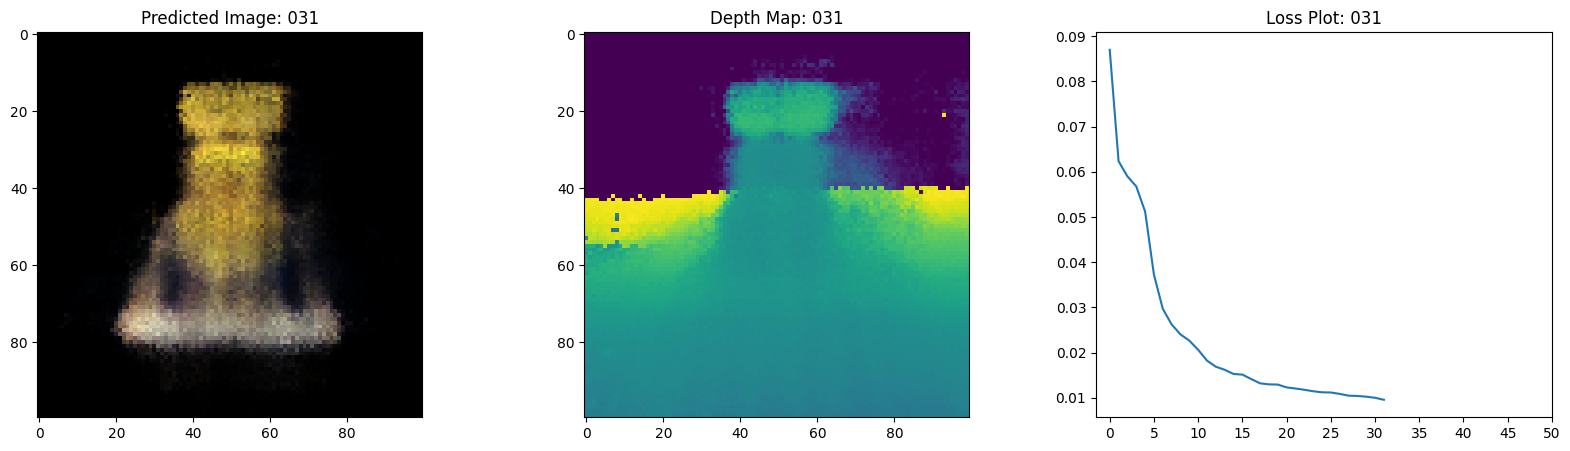

16/16 [==============================] - 118s 7s/step - loss: 0.0096 - psnr: 20.3486 - val_loss: 0.0100 - val_psnr: 20.0826
Epoch 33/50
1/1 [==============================] - 3s 3s/step- loss: 0.0096 - psnr: 20.33


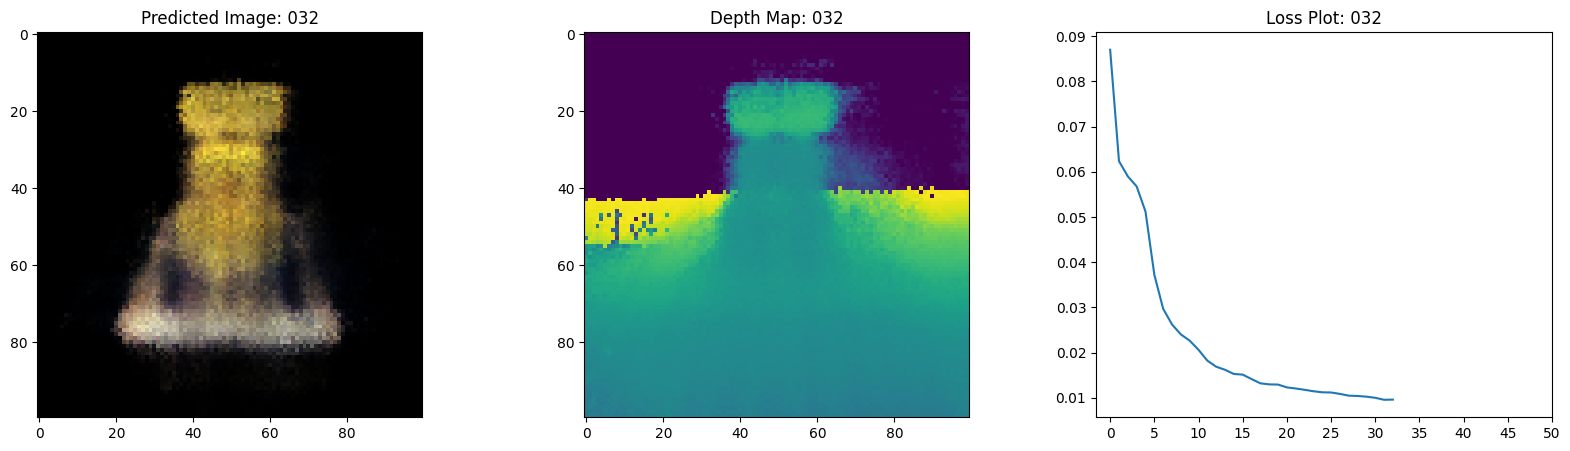

16/16 [==============================] - 109s 6s/step - loss: 0.0096 - psnr: 20.3334 - val_loss: 0.0099 - val_psnr: 20.1585
Epoch 34/50
1/1 [==============================] - 4s 4s/step- loss: 0.0095 - psnr: 20.37


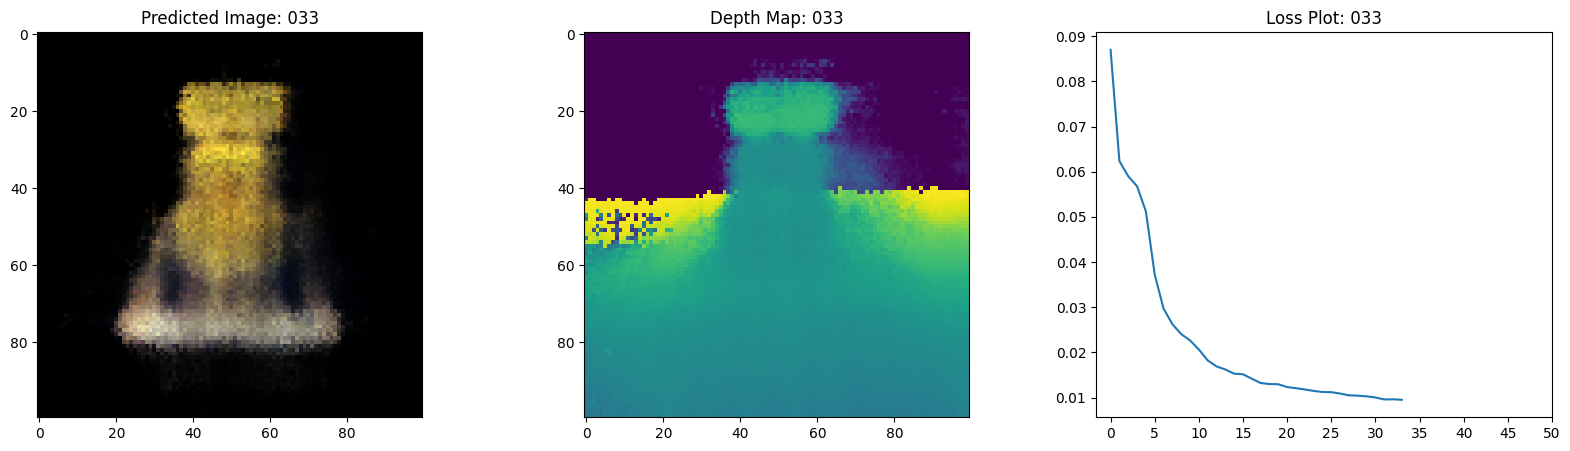

16/16 [==============================] - 118s 7s/step - loss: 0.0095 - psnr: 20.3774 - val_loss: 0.0095 - val_psnr: 20.3416
Epoch 35/50
1/1 [==============================] - 3s 3s/step- loss: 0.0094 - psnr: 20.41


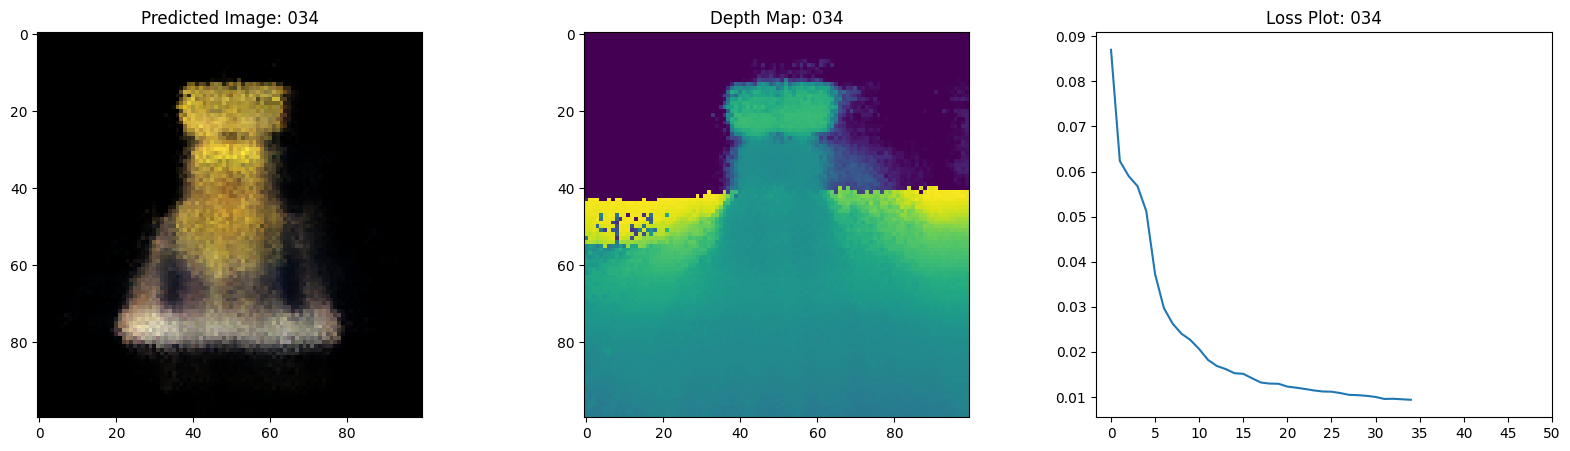

16/16 [==============================] - 114s 7s/step - loss: 0.0094 - psnr: 20.4183 - val_loss: 0.0096 - val_psnr: 20.2625
Epoch 36/50
1/1 [==============================] - 3s 3s/step- loss: 0.0093 - psnr: 20.48


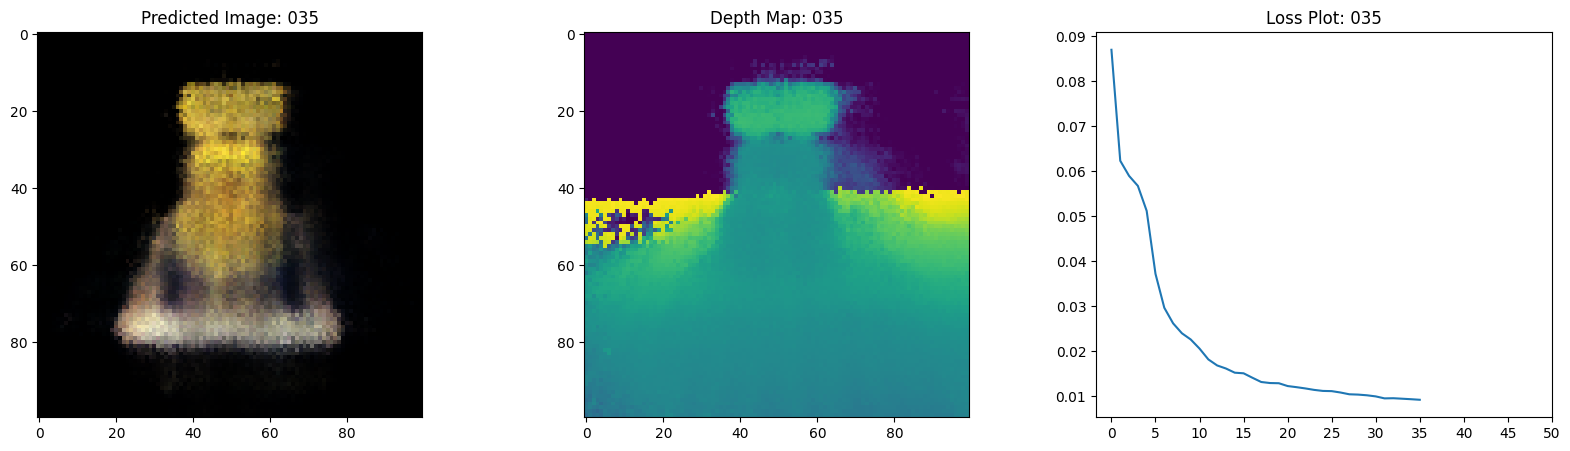

16/16 [==============================] - 125s 7s/step - loss: 0.0093 - psnr: 20.4809 - val_loss: 0.0096 - val_psnr: 20.2726
Epoch 37/50
1/1 [==============================] - 4s 4s/step- loss: 0.0091 - psnr: 20.57


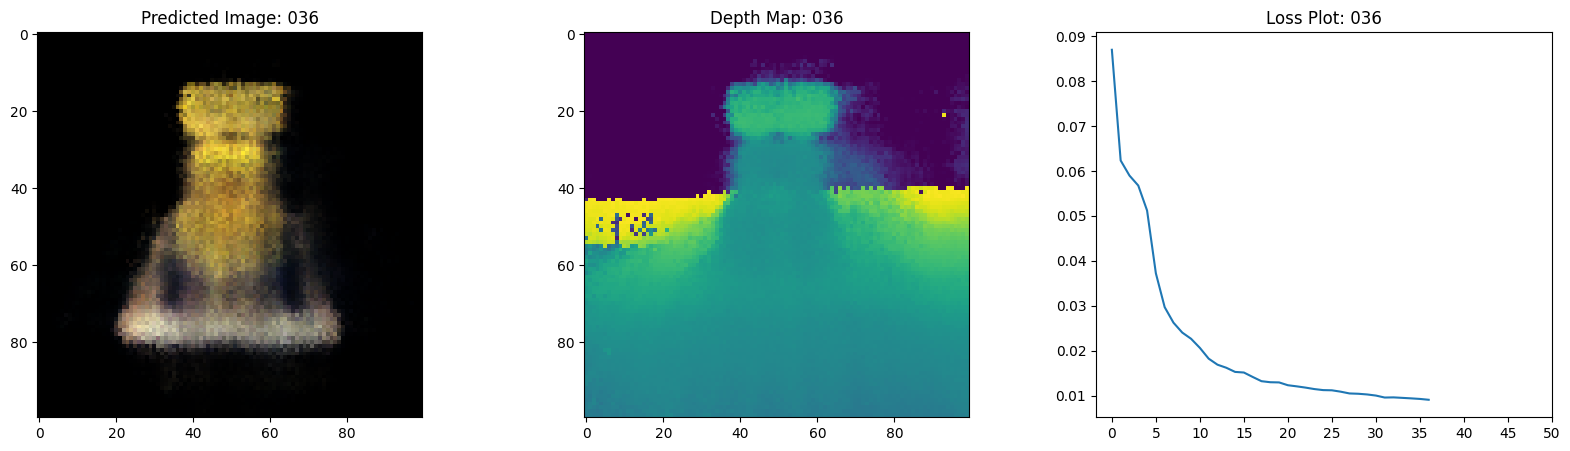

16/16 [==============================] - 134s 8s/step - loss: 0.0091 - psnr: 20.5732 - val_loss: 0.0091 - val_psnr: 20.5415
Epoch 38/50
1/1 [==============================] - 4s 4s/step- loss: 0.0090 - psnr: 20.63


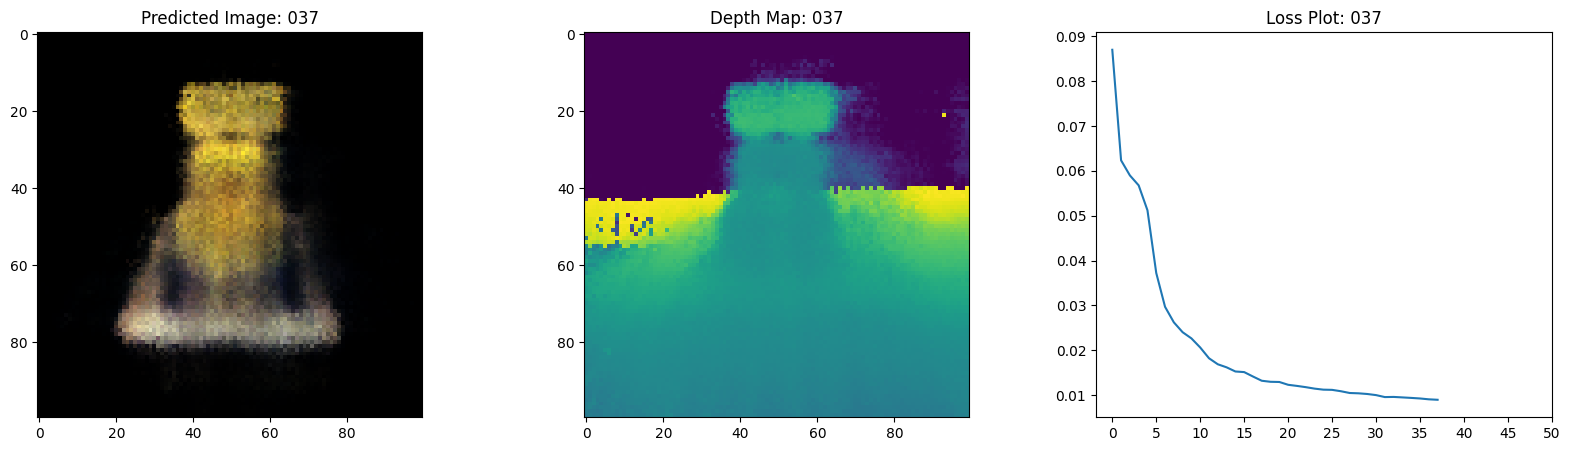

16/16 [==============================] - 119s 7s/step - loss: 0.0090 - psnr: 20.6346 - val_loss: 0.0091 - val_psnr: 20.4831
Epoch 39/50
1/1 [==============================] - 3s 3s/step- loss: 0.0088 - psnr: 20.70


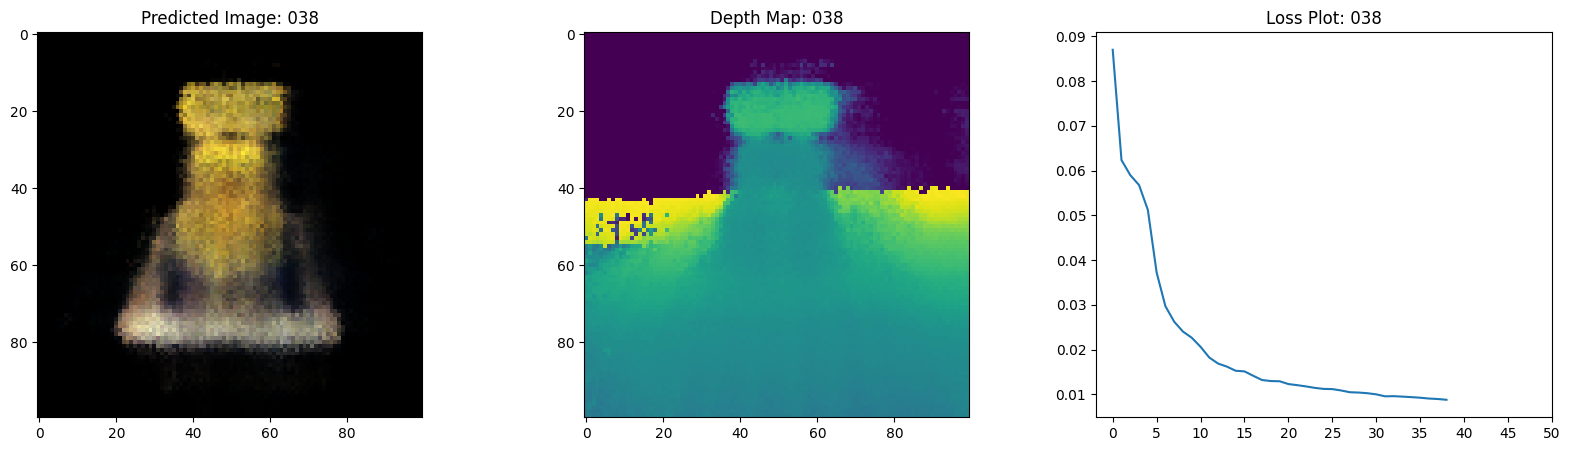

16/16 [==============================] - 122s 7s/step - loss: 0.0088 - psnr: 20.7092 - val_loss: 0.0089 - val_psnr: 20.6133
Epoch 40/50
1/1 [==============================] - 3s 3s/step- loss: 0.0089 - psnr: 20.62


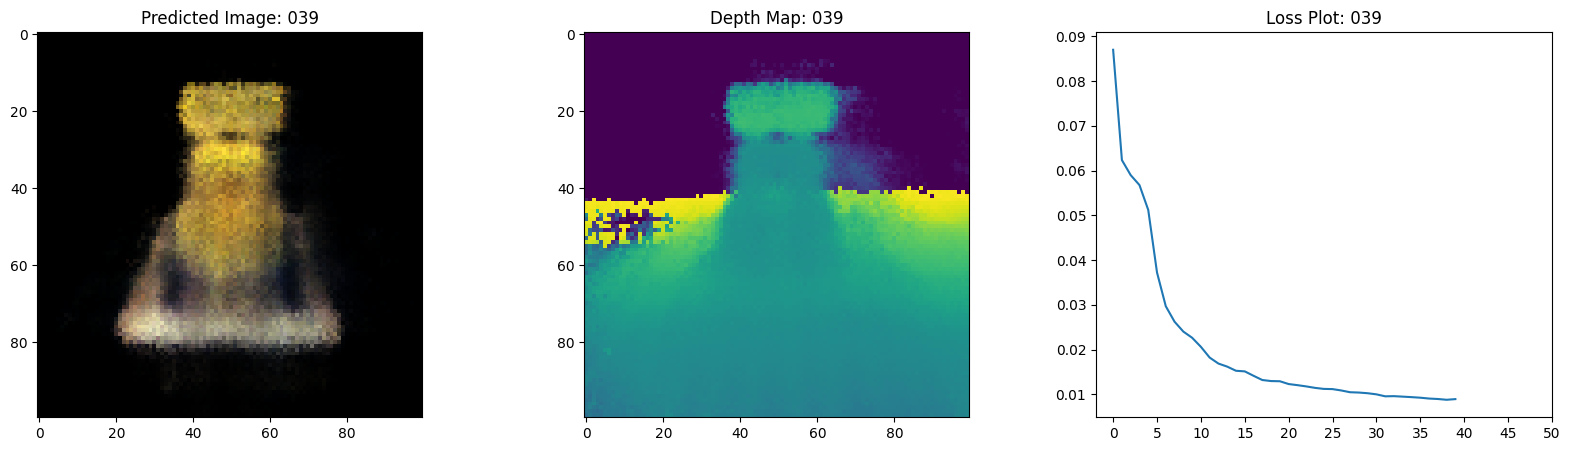

16/16 [==============================] - 112s 6s/step - loss: 0.0089 - psnr: 20.6288 - val_loss: 0.0089 - val_psnr: 20.5428
Epoch 41/50
1/1 [==============================] - 4s 4s/step- loss: 0.0088 - psnr: 20.69


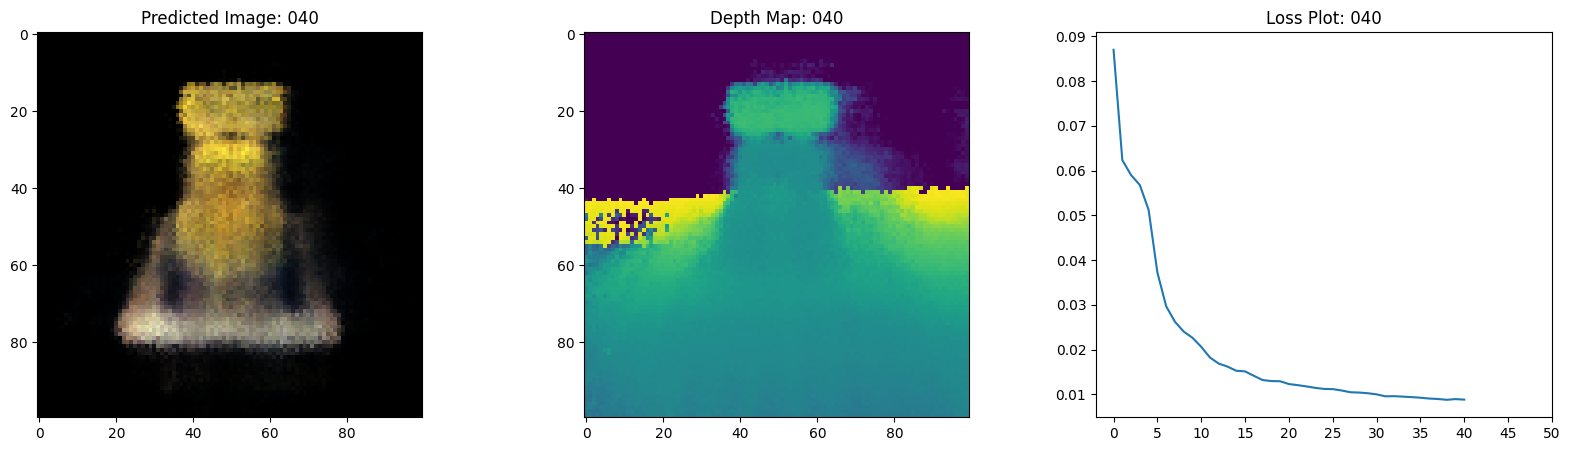

16/16 [==============================] - 121s 7s/step - loss: 0.0088 - psnr: 20.6965 - val_loss: 0.0090 - val_psnr: 20.5398
Epoch 42/50
1/1 [==============================] - 3s 3s/step- loss: 0.0087 - psnr: 20.77


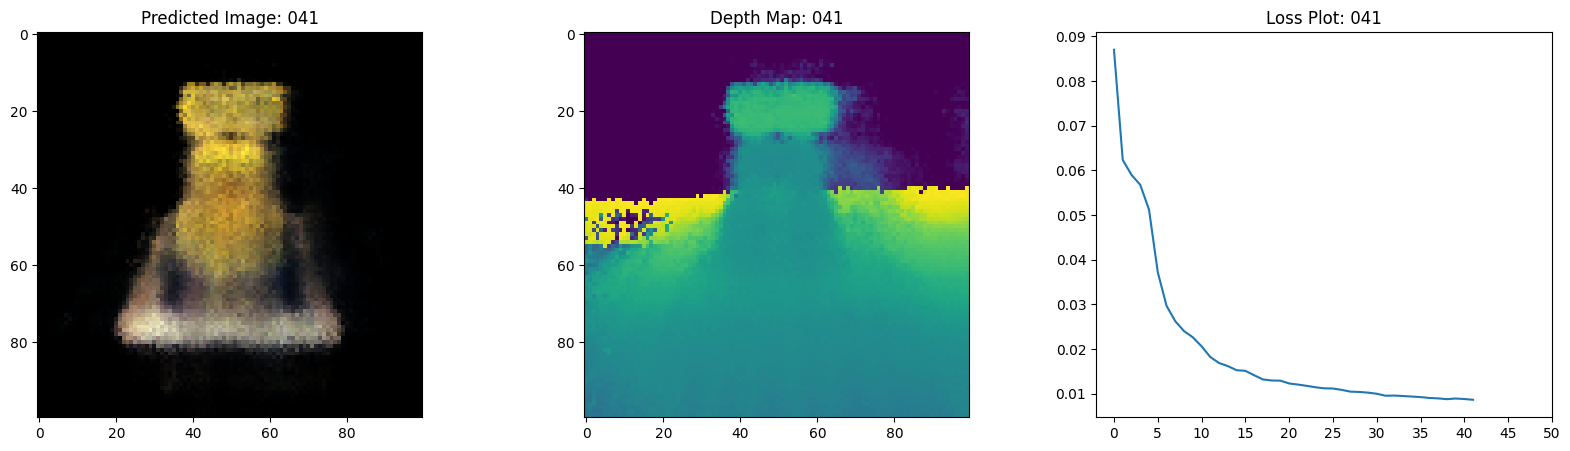

16/16 [==============================] - 114s 7s/step - loss: 0.0087 - psnr: 20.7771 - val_loss: 0.0090 - val_psnr: 20.5634
Epoch 43/50
1/1 [==============================] - 4s 4s/step- loss: 0.0087 - psnr: 20.75


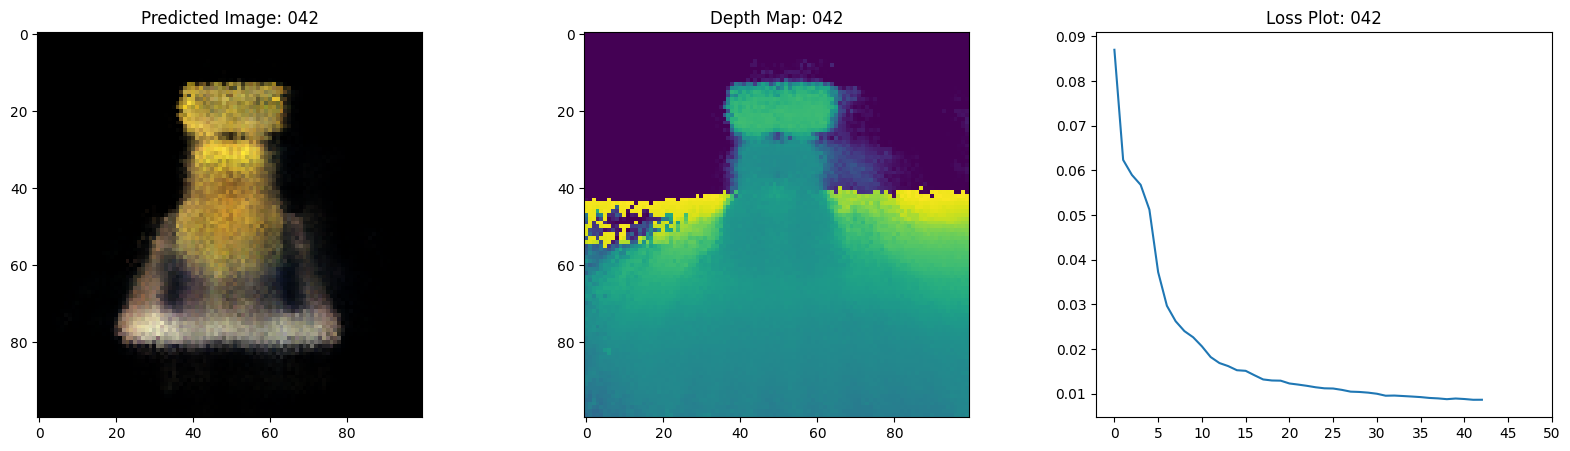

16/16 [==============================] - 125s 7s/step - loss: 0.0087 - psnr: 20.7511 - val_loss: 0.0088 - val_psnr: 20.6706
Epoch 44/50
1/1 [==============================] - 3s 3s/step- loss: 0.0085 - psnr: 20.87


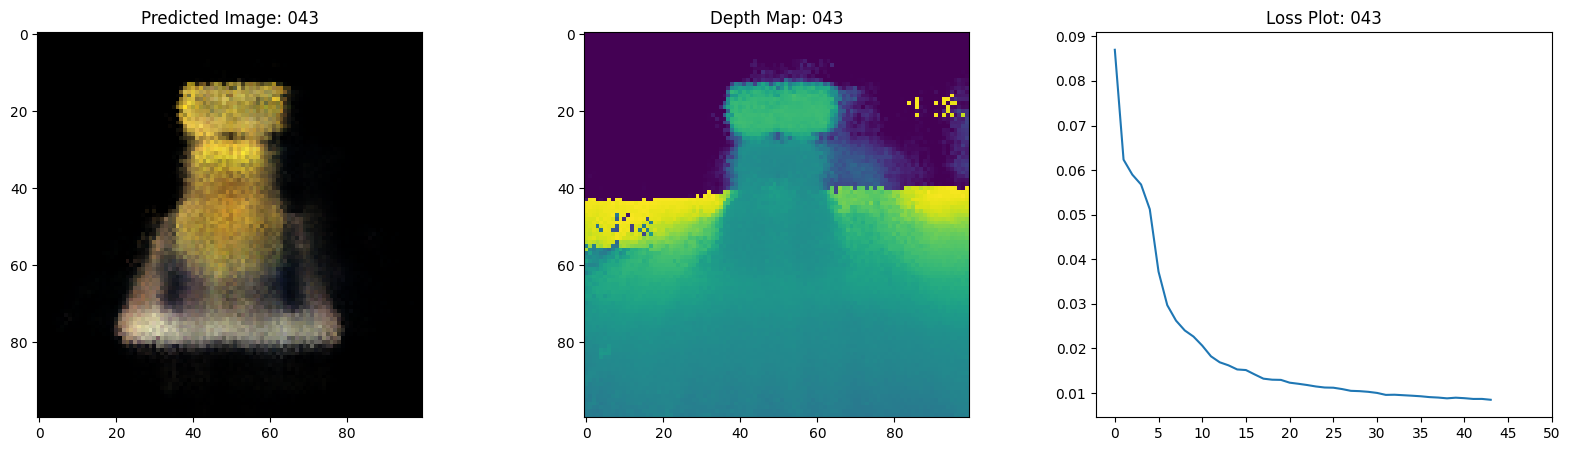

16/16 [==============================] - 106s 6s/step - loss: 0.0085 - psnr: 20.8714 - val_loss: 0.0084 - val_psnr: 20.8662
Epoch 45/50
1/1 [==============================] - 4s 4s/step- loss: 0.0084 - psnr: 20.89


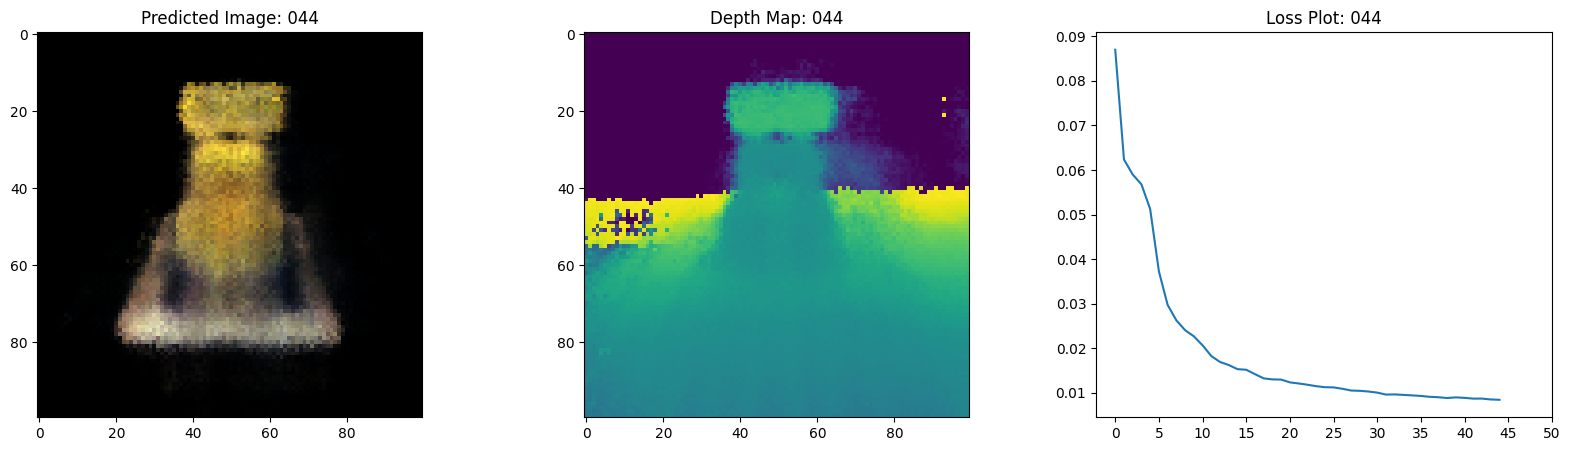

16/16 [==============================] - 120s 7s/step - loss: 0.0084 - psnr: 20.8992 - val_loss: 0.0085 - val_psnr: 20.8147
Epoch 46/50
1/1 [==============================] - 3s 3s/step- loss: 0.0085 - psnr: 20.83


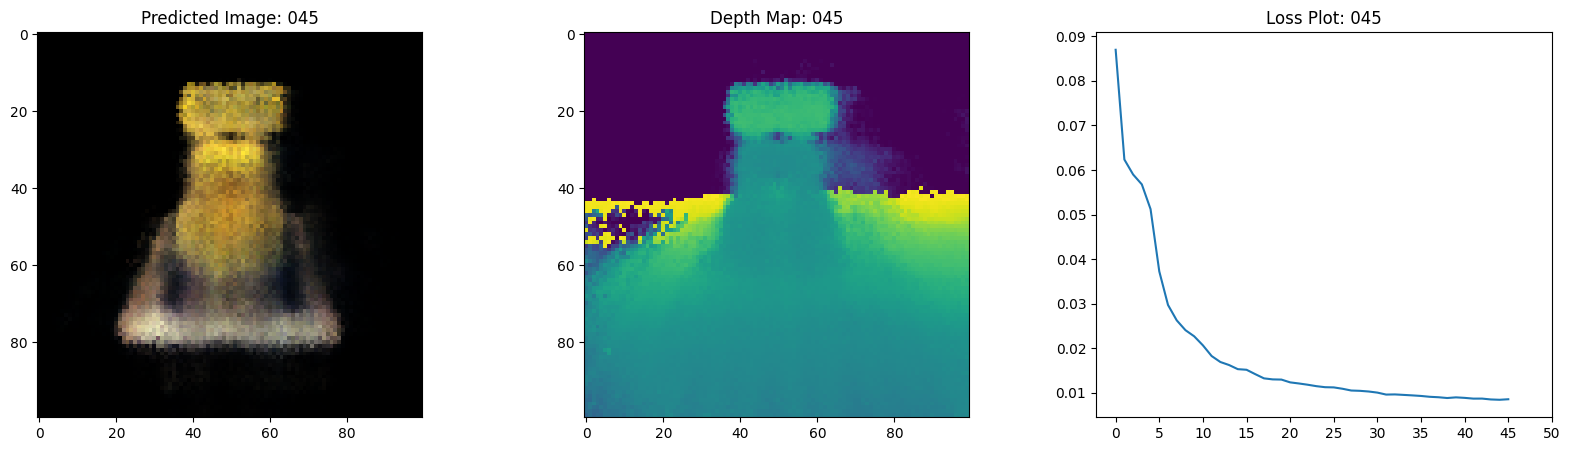

16/16 [==============================] - 116s 7s/step - loss: 0.0085 - psnr: 20.8367 - val_loss: 0.0085 - val_psnr: 20.8107
Epoch 47/50
1/1 [==============================] - 3s 3s/step- loss: 0.0082 - psnr: 21.02


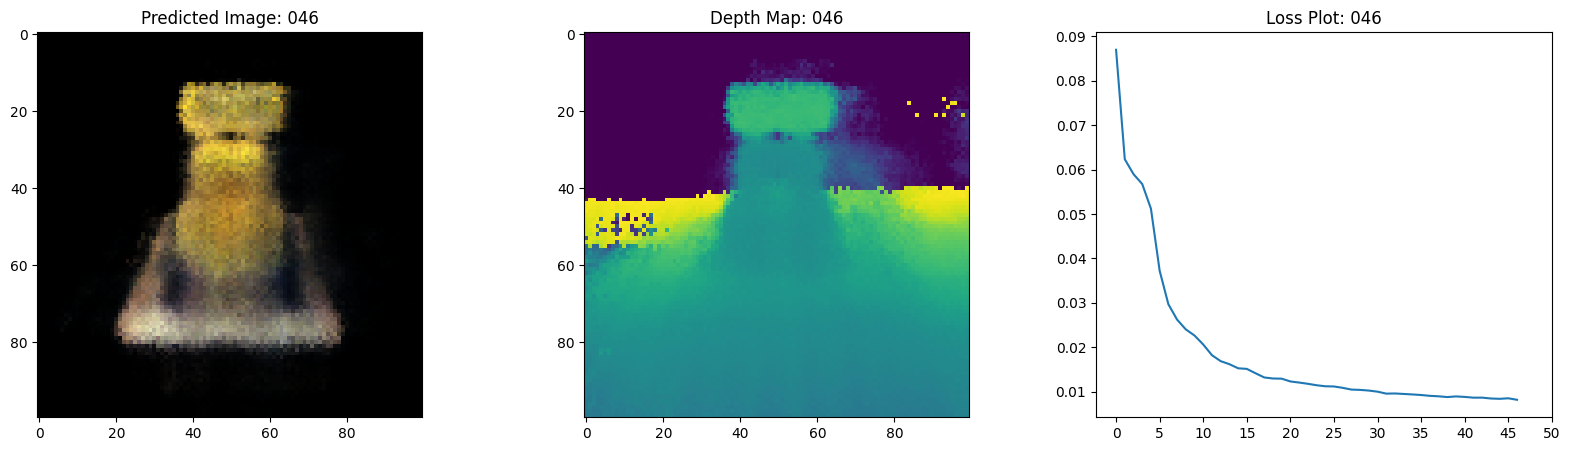

16/16 [==============================] - 109s 6s/step - loss: 0.0082 - psnr: 21.0299 - val_loss: 0.0083 - val_psnr: 20.9211
Epoch 48/50
1/1 [==============================] - 4s 4s/step- loss: 0.0082 - psnr: 21.02


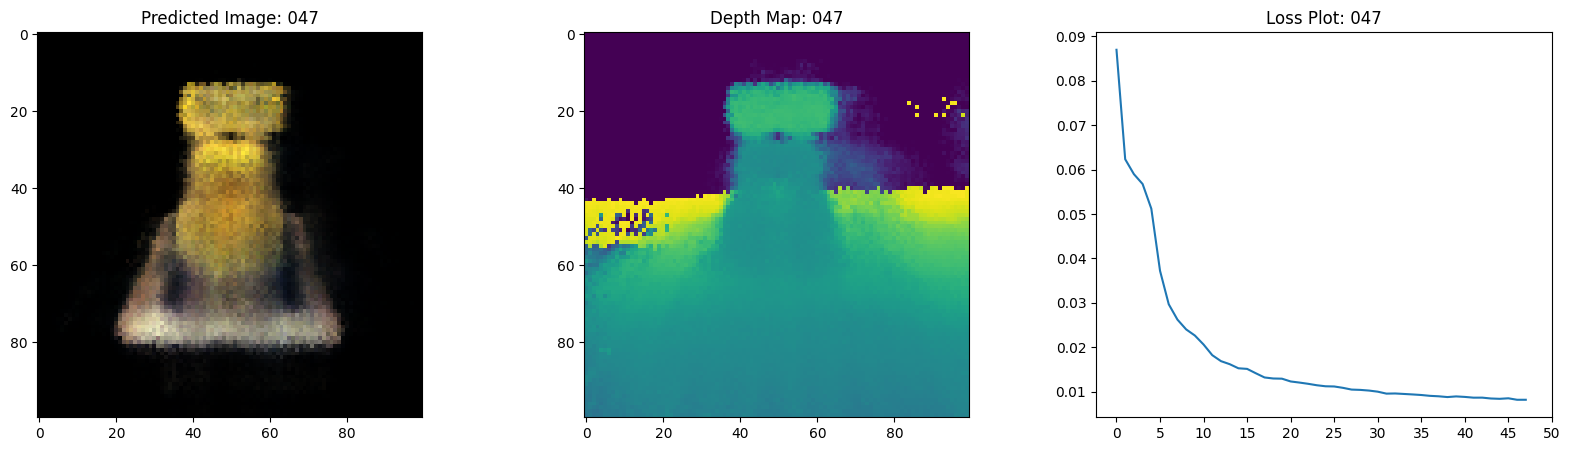

16/16 [==============================] - 106s 6s/step - loss: 0.0082 - psnr: 21.0223 - val_loss: 0.0085 - val_psnr: 20.7879
Epoch 49/50
1/1 [==============================] - 3s 3s/step- loss: 0.0082 - psnr: 20.99


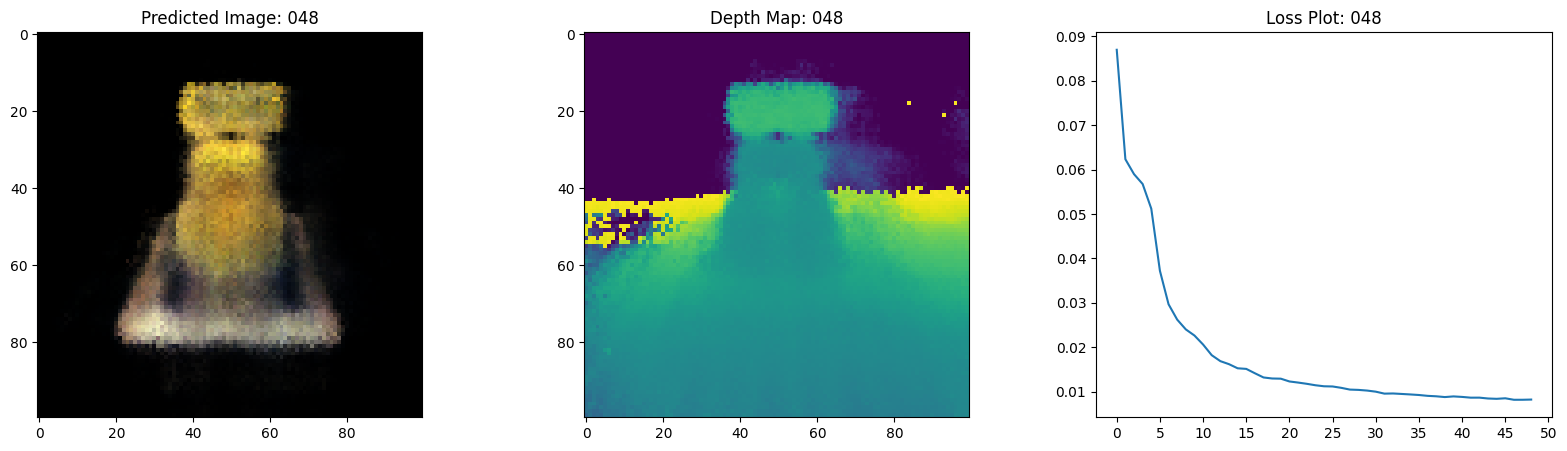

16/16 [==============================] - 99s 6s/step - loss: 0.0082 - psnr: 20.9915 - val_loss: 0.0084 - val_psnr: 20.8467
Epoch 50/50
16/16 [==============================] - ETA: 0s - loss: 0.0080 - psnr: 21.1380

In [8]:
class NeRF(keras.Model):
    def __init__(self, nerf_model):
        super().__init__()
        self.nerf_model = nerf_model

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_metric = keras.metrics.Mean(name="psnr")

    def train_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        with tf.GradientTape() as tape:
            # Get the predictions from the model.
            rgb, _ = render_rgb_depth(
                model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
            )
            loss = self.loss_fn(images, rgb)

        # Get the trainable variables.
        trainable_variables = self.nerf_model.trainable_variables

        # Get the gradeints of the trainiable variables with respect to the loss.
        gradients = tape.gradient(loss, trainable_variables)

        # Apply the grads and optimize the model.
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    def test_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        # Get the predictions from the model.
        rgb, _ = render_rgb_depth(
            model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
        )
        loss = self.loss_fn(images, rgb)

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_metric]


test_imgs, test_rays = next(iter(train_ds))
test_rays_flat, test_t_vals = test_rays

loss_list = []


class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)
        test_recons_images, depth_maps = render_rgb_depth(
            model=self.model.nerf_model,
            rays_flat=test_rays_flat,
            t_vals=test_t_vals,
            rand=True,
            train=False,
        )

        # Plot the rgb, depth and the loss plot.
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(keras.utils.array_to_img(test_recons_images[0]))
        ax[0].set_title(f"Predicted Image: {epoch:03d}")

        ax[1].imshow(keras.utils.array_to_img(depth_maps[0, ..., None]))
        ax[1].set_title(f"Depth Map: {epoch:03d}")

        ax[2].plot(loss_list)
        ax[2].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
        ax[2].set_title(f"Loss Plot: {epoch:03d}")

        fig.savefig(f"images/{epoch:03d}.png")
        plt.show()
        plt.close()


num_pos = H * W * NUM_SAMPLES
nerf_model = get_nerf_model(num_layers=8, num_pos=num_pos)

model = NeRF(nerf_model)
model.compile(
    optimizer=keras.optimizers.Adam(), loss_fn=keras.losses.MeanSquaredError()
)

# Create a directory to save the images during training.
if not os.path.exists("images"):
    os.makedirs("images")

model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[TrainMonitor()],
    steps_per_epoch=split_index // BATCH_SIZE,
)


def create_gif(path_to_images, name_gif):
    filenames = glob.glob(path_to_images)
    filenames = sorted(filenames)
    images = []
    for filename in tqdm(filenames):
        images.append(imageio.imread(filename))
    kargs = {"duration": 0.25}
    imageio.mimsave(name_gif, images, "GIF", **kargs)


create_gif("images/*.png", "training.gif")

1/1 [==============================] - 3s 3s/step


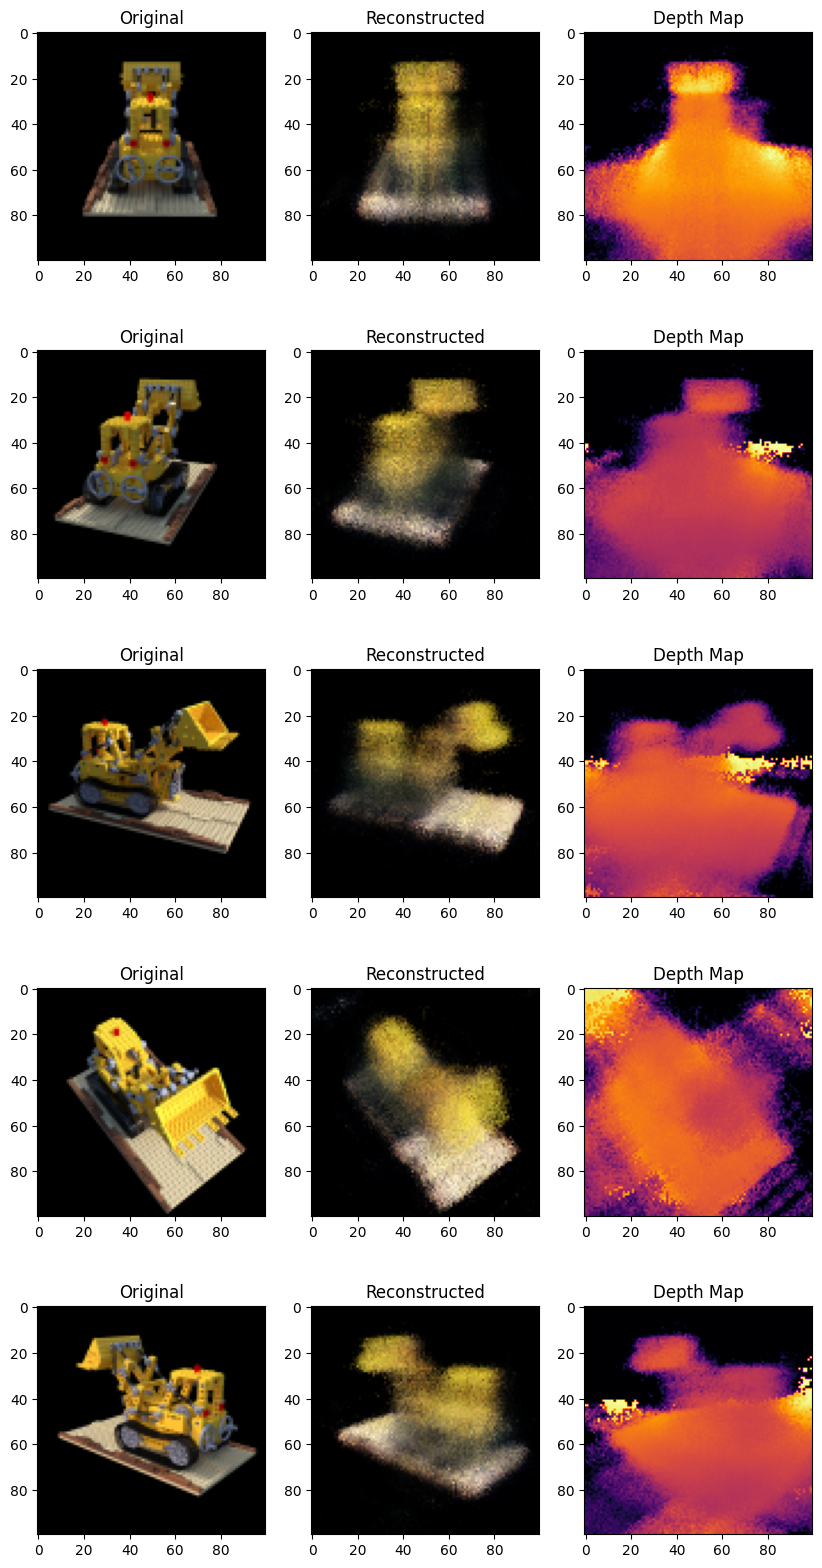

In [ ]:
# Get the trained NeRF model and infer.
nerf_model = model.nerf_model
test_recons_images, depth_maps = render_rgb_depth(
    model=nerf_model,
    rays_flat=test_rays_flat,
    t_vals=test_t_vals,
    rand=True,
    train=False,
)
test_imgs2,test_recons_images2 = [], []
# Create subplots.
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))
i = 0
for ax, ori_img, recons_img, depth_map in zip(
    axes, test_imgs, test_recons_images, depth_maps
):
    keras.utils.array_to_img(ori_img).save(f"data_output/Original_{i}.png")
    test_imgs2.append(keras.utils.array_to_img(ori_img))
    ax[0].imshow(keras.utils.array_to_img(ori_img))
    ax[0].set_title("Original")
    keras.utils.array_to_img(recons_img).save(f"data_output/Reconstructed_{i}.png")
    test_recons_images2.append(keras.utils.array_to_img(recons_img))
    ax[1].imshow(keras.utils.array_to_img(recons_img))
    ax[1].set_title("Reconstructed")
    i += 1
    ax[2].imshow(
        keras.utils.array_to_img(depth_map[..., None]), cmap="inferno"
    )
    ax[2].set_title("Depth Map")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5
5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Noise mean:  1.150476e-06
Noise std:  2.4859985e-06


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Noise mean:  1.0057169e-06
Noise std:  2.5639672e-06


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Noise mean:  7.920589e-07
Noise std:  3.2751655e-06


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Noise mean:  -1.7066414e-07
Noise std:  4.4717876e-06
Noise mean:  3.5638928e-07
Noise std:  3.4515438e-06


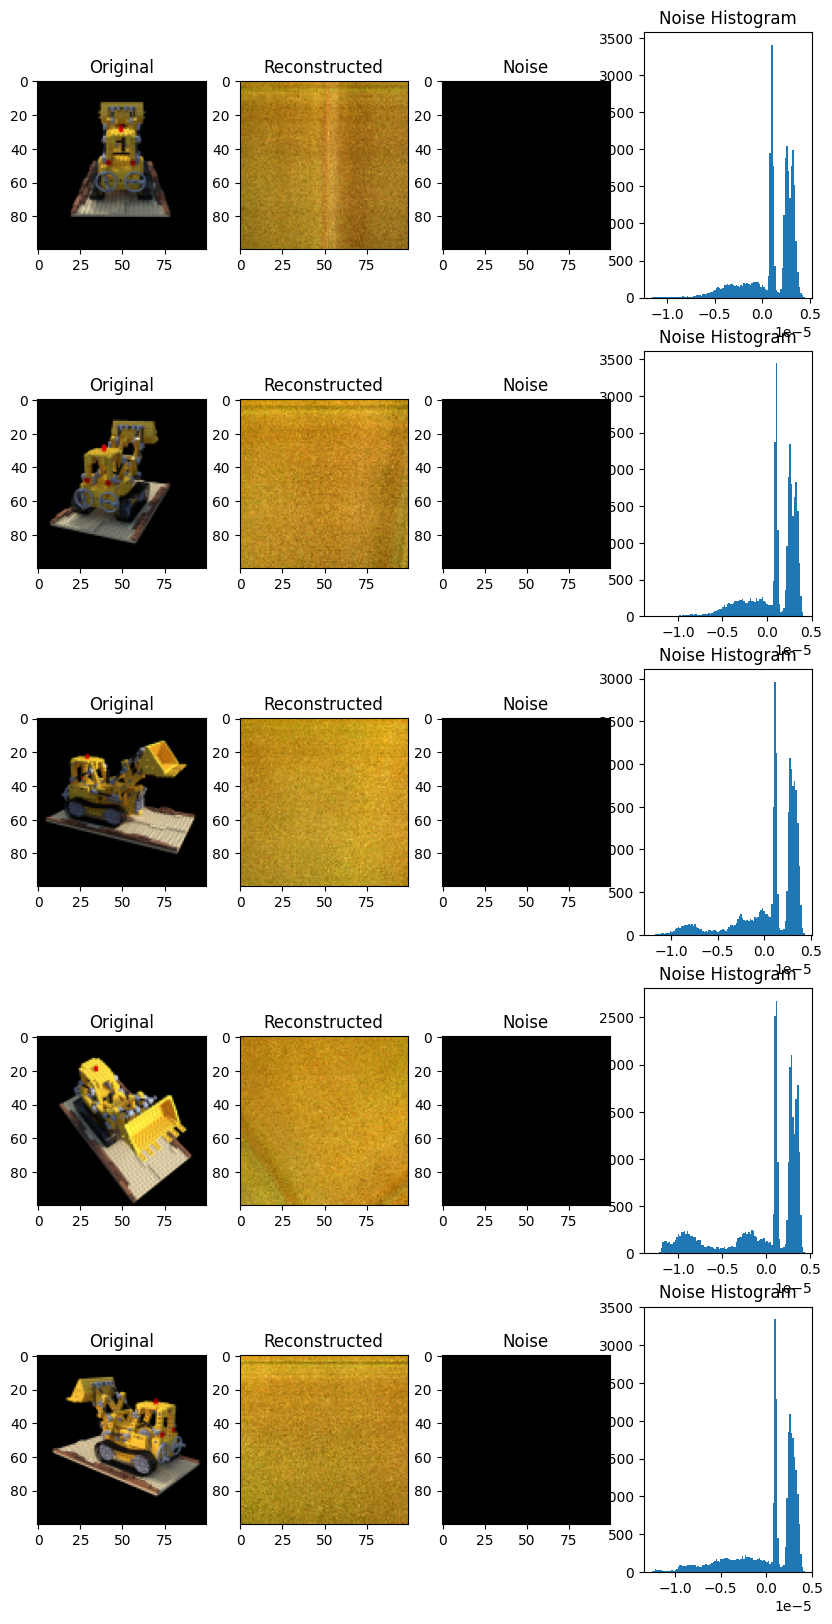

In [ ]:
# detect if the reconstracted images and original has gaussian noise, and plot it
def plot_noise(ori_img, recons_img, ax):
    ori_img = np.array(ori_img)
    recons_img = np.array(recons_img)
    ax[1].imshow(keras.utils.array_to_img(recons_img))
    ax[1].set_title("Reconstructed")
    ax[0].imshow(keras.utils.array_to_img(ori_img))
    ax[0].set_title("Original")
    ori_img = ori_img.astype('float32')
    recons_img = recons_img.astype('float32')
    ori_img = ori_img / 255.0
    recons_img = recons_img / 255.0
    noise = recons_img - ori_img
    noise = noise.astype('float32')
    noise = noise / 255.0
    ax[2].imshow(noise)
    ax[2].set_title("Noise")
    ax[3].hist(noise.flatten(), bins=100)
    ax[3].set_title("Noise Histogram")
    return noise

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 20))
# plot the noise of each image
for i in range(5):
    noise = plot_noise(test_imgs[i], test_recons_images[i], axes[i])
    print("Noise mean: ", np.mean(noise))
    print("Noise std: ", np.std(noise))
    